Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

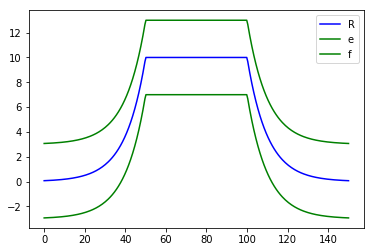

In [7]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [1, 1]
q2 = [.5, .5]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])


Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [8]:
N = len(x_path)
H = 10  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0][:]  # Initial state.
# Random initial action path.
#us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
us_init = np.zeros((H - 1, dynamics.action_size))

for i in range(0, int(N - H) + 1):
    k = 1
    if i % k != 0:
        continue
        #pass
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]



iteration 0 accepted [0.0080592] [4.49998003e+00 9.38890168e-02 1.00001904e+01 7.52651967e-03] [ 4.53932487e-06 -1.97169127e-04]
iteration 0 accepted [0.008972] [4.99998593e+00 9.92989318e-02 1.00002631e+01 7.70408542e-03] [ 2.44352309e-06 -8.37251005e-04]


/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 0 accepted [0.01002043] [5.49999476e+00 1.04799827e-01 1.00003420e+01 8.16509053e-03] [ 6.10606969e-08 -1.07178701e-03]
iteration 0 accepted [0.0112222] [6.00000717e+00 1.10425605e-01 1.00004271e+01 8.76049194e-03] [-2.61726441e-06 -1.08866251e-03]
iteration 0 accepted [0.01259231] [6.50002349e+00 1.16218385e-01 1.00005181e+01 9.40677531e-03] [-5.58351730e-06 -1.00416585e-03]
iteration 0 accepted [0.01413953] [ 7.00004364  0.1222269  10.00061484  0.01005983] [-8.82520306e-06 -8.92624487e-04]
iteration 0 accepted [0.01583156] [ 7.50006909  0.12743973 10.00068916  0.01041375] [-1.12133787e-05 -7.22396427e-04]
iteration 0 accepted [0.01769319] [ 8.00009125  0.13177282 10.0007139   0.01041143] [-1.07503883e-05 -4.97253322e-04]
iteration 0 accepted [0.0198096] [ 8.50010637  0.13867242 10.00079325  0.01101329] [-1.26003787e-05 -5.03764261e-04]
iteration 0 accepted [0.02213762] [ 9.00012193  0.14592599 10.00087674  0.01163786] [-1.45789053e-05 -5.11352120e-04]
iteration 0 accepted [

iteration 0 accepted [13.07757369] [41.18441603  3.75349212 10.02373289  0.3105829 ] [-0.00065686 -0.01455153]
iteration 0 accepted [14.55820231] [41.64609426  3.95535649 10.02606224  0.33128768] [-0.00077768 -0.01683812]
iteration 0 accepted [16.19834571] [42.1106016   4.1467467  10.02811387  0.3469887 ] [-0.00083811 -0.0172433 ]
iteration 0 accepted [18.03460169] [42.57102515  4.34837288 10.03032296  0.36289252] [-0.00090189 -0.01869   ]
iteration 0 accepted [20.08938369] [43.02793122  4.5581942  10.03271993  0.37965248] [-0.00097073 -0.01989262]
iteration 0 accepted [22.39179312] [43.4809892   4.77658874 10.03532264  0.39718526] [-0.00104508 -0.02097715]
iteration 0 accepted [24.97468242] [43.92985918  5.00388194 10.03815077  0.41544358] [-0.00112543 -0.02202612]
iteration 0 accepted [27.87531479] [44.37418951  5.24035569 10.04122601  0.43440362] [-0.00121234 -0.02309294]
iteration 0 accepted [31.13611756] [44.81361314  5.48625784 10.04457216  0.4540553 ] [-0.00130644 -0.02421365]
i

iteration 0 failed 122.43118240227966 [7.63054469e+01 9.31444818e+00 1.01071693e+01 1.52383853e-04] [0. 0.]
iteration 0 failed 122.32296340549425 [7.68108054e+01 9.31452519e+00 1.01071693e+01 1.52383853e-04] [0. 0.]
iteration 0 failed 122.21505863681061 [7.73161649e+01 9.31435196e+00 1.01071715e+01 9.73657773e-05] [0. 0.]
iteration 0 failed 122.10736366362974 [7.78215235e+01 9.31440117e+00 1.01071715e+01 9.73657773e-05] [0. 0.]
iteration 0 failed 121.99994057120645 [7.83268821e+01 9.31445037e+00 1.01071715e+01 9.73657773e-05] [0. 0.]
iteration 0 failed 121.89278935954232 [7.88322407e+01 9.31449957e+00 1.01071715e+01 9.73657773e-05] [0. 0.]
iteration 0 failed 121.78591002863885 [7.93375992e+01 9.31454878e+00 1.01071715e+01 9.73657773e-05] [0. 0.]
iteration 0 failed 121.67930257849764 [7.98429578e+01 9.31459798e+00 1.01071715e+01 9.73657773e-05] [0. 0.]
iteration 0 failed 121.57296700912023 [8.03483164e+01 9.31464719e+00 1.01071715e+01 9.73657773e-05] [0. 0.]
iteration 0 failed 121.46690

iteration 0 accepted [73.75633132] [112.43141961   2.72819989  10.26159237  -0.29517607] [-0.00717311 -0.01855179]
iteration 0 accepted [73.10216014] [112.93054163   2.59911841  10.2679731   -0.2829777 ] [-0.00737562 -0.01814562]
iteration 0 accepted [72.43052097] [113.43128241   2.475361    10.27419102  -0.27111655] [-0.00757336 -0.01770223]
iteration 0 accepted [71.74274907] [113.93351838   2.35677116  10.28020371  -0.25957856] [-0.00776498 -0.01721452]
iteration 0 accepted [71.0400277] [114.43719103   2.2432726   10.28605276  -0.24842649] [-0.00795172 -0.01671996]
iteration 0 accepted [70.32301168] [114.9422492    2.13473523  10.2918221   -0.23769561] [-0.00813615 -0.01624366]
iteration 0 accepted [69.59295551] [115.44852954   2.03086581  10.29742566  -0.22726461] [-0.00831565 -0.01572236]
iteration 0 accepted [68.85135837] [115.95597052   1.93159146  10.30286364  -0.21718955] [-0.00849017 -0.01518961]
iteration 0 accepted [68.09940162] [116.46449416   1.83676759  10.30813659  -0.20

iteration 0 accepted [23.19053648] [ 1.48607340e+02  7.45628280e-02  1.03780063e+01 -7.95351598e-03] [-0.01672119 -0.00089529]


The result can be visulized by executing the following code.

In [9]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

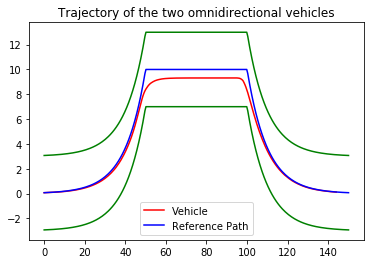

In [10]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [ ]:
N = len(x_path)
H = 10  # Number of time steps in trajectory.
J_hist = []
expert_pts = []


num_pts = 50000
#for pt in range(num_pts):
#    x0 = [] # Initial state.
pt = 0
for pt in range(num_pts):
    i = pt % (len(x_path) - H - 1)
    #i = random.randint(0, len(x_path) - H - 1)
    x0 = [x_path[i][0] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][1] + 3.0 * (2 * random.random() - 1.0), \
          x_path[i][2] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][3] + 3.0 * (2 * random.random() - 1.0)]

    # Random initial action path.
    us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
    #us_init = np.zeros((N, dynamics.action_size))
    print("Point %d" % pt)
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, \
                   x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x = [x0] + x_path_[0:H]
    u = us[0]
    expert_pts = expert_pts + [[x, us[0]]]


Point 0
iteration 0 accepted [71.29871619] [1.70989074 1.01141881 9.07863539 1.78649814] [0.04516505 0.1382129 ]
Point 1
iteration 0 accepted [262.27393114] [-0.9286788   0.11143251  9.1382446   0.60150914] [0.03556622 0.25673451]
Point 2
iteration 0 accepted [34.18143133] [ 5.37231293  0.11565504 10.20600229 -0.10051019] [-0.00545532  0.32746273]
Point 3
iteration 0 accepted [4.5319092] [ 5.58985767 -0.12030306 10.20268646 -0.05975047] [-0.00731177  0.0742742 ]
Point 4
iteration 0 accepted [37.33190423] [ 5.14374806 -0.74476389  9.54040048 -0.08871467] [0.01323453 0.23487406]
Point 5
iteration 0 accepted [25.73124128] [ 5.87252085 -0.58056887 10.65797514 -0.82346718] [-0.02957238 -0.16782562]
Point 6
iteration 0 accepted [208.40210823] [ 0.49564845  1.18909525 10.51763764 -3.86934616] [-0.02625137  0.04441945]
Point 7
iteration 0 accepted [36.74195944] [ 6.29556851 -0.48820814  9.3950585  -0.6909331 ] [0.02179561 0.11869266]
Point 8
iteration 0 accepted [377.53318066] [ 5.53469876  3.

Point 70
iteration 0 accepted [268.87041212] [39.24344811  7.02707566  9.02753951  0.85068011] [0.02831334 0.14546614]
Point 71
iteration 0 accepted [77.32406406] [39.53898204  2.86739834 10.90568338  0.99223904] [-0.01916814 -0.05110518]
Point 72
iteration 0 accepted [252.00764966] [37.94785307  4.39205173 10.75267175 -1.90670639] [-0.02862372  0.44107909]
Point 73
iteration 0 accepted [74.6807203] [38.9701364   2.91465269  9.65767206  0.87592274] [ 0.01045344 -0.06237969]
Point 74
iteration 0 accepted [104.48522734] [40.34771532  3.80772875 10.36070185 -1.1831005 ] [-0.01205     0.26758834]
Point 75
iteration 0 accepted [75.92350506] [40.56184156  4.35900482  9.70046548  0.26169588] [ 0.01653775 -0.15737297]
Point 76
iteration 0 accepted [39.25570795] [41.66138401  3.59508799  9.95609673  0.42094411] [ 0.00537282 -0.16693804]
Point 77
iteration 0 accepted [71.79362114] [41.0461465   3.07561609  9.1277632  -0.43532494] [0.04472336 0.34269108]
Point 78
iteration 0 accepted [29.90506265

Point 140
iteration 0 accepted [340.57390076] [72.49357174  5.51074847  9.09085094 -0.35685746] [ 0.02311007 -0.37174918]
Point 141
iteration 0 accepted [451.09230323] [71.2329874  13.46467443  9.95393235  2.45203287] [-0.00762333 -0.057029  ]
Point 142
iteration 0 accepted [135.44238634] [74.85067958  8.71220638  9.72158061  0.20420891] [ 0.00747407 -0.08660802]
Point 143
iteration 0 accepted [567.17929918] [72.7948346  11.07865128  9.95690902 -2.58678007] [0.00045177 0.39809558]
Point 144
iteration 0 accepted [625.22647609] [69.59295239 12.39321734  9.57448806  1.98978581] [ 0.00919292 -0.16599873]
Point 145
iteration 0 accepted [165.08468891] [7.48154635e+01 9.74694351e+00 9.75615757e+00 5.31856270e-03] [0.00793539 0.38404229]
Point 146
iteration 0 accepted [144.96884327] [76.62075721  9.65762501  9.39243713 -0.25010642] [ 0.016089   -0.10088447]
Point 147
iteration 0 accepted [299.38455414] [71.07498102  8.43995244 10.82393842 -3.26409654] [-0.0310316  0.0108778]
Point 148
iteratio

Point 208
iteration 0 accepted [204.86984389] [106.65238927   6.42196188   9.80929655  -0.60822103] [0.00301086 0.54146305]
Point 209
iteration 0 accepted [374.75925212] [105.00784028   9.23724128  10.21690621  -6.17366916] [-0.00692086  0.14856281]
Point 210
iteration 0 accepted [452.09985749] [109.55330599   8.64048996  10.70465717   1.26232299] [-0.02391789  0.11149834]
Point 211
iteration 0 accepted [35.48299729] [109.46979092   3.10680112   9.32506286  -0.27698758] [0.01654002 0.26175551]
Point 212
iteration 0 accepted [470.11890897] [102.23473326   7.81645315   9.15593201  -3.67207557] [ 0.01814393 -0.03855203]
Point 213
iteration 0 accepted [347.21943479] [102.28222425   3.65735273   9.92562633  -3.38493137] [-0.0015545   0.05465613]
Point 214
iteration 0 accepted [160.65341746] [108.11963325   3.68344258   9.57270014  -1.11215356] [0.01343814 0.07683064]
Point 215
iteration 0 accepted [86.82315263] [ 1.09752573e+02  9.29803962e-01  9.27516059e+00 -2.48204272e-02] [ 0.02908095 -

Point 273
iteration 0 accepted [229.65094979] [134.46828629   0.93282063  10.39589176   4.18604961] [-0.01937082 -0.2962954 ]
Point 274
iteration 0 accepted [99.44899006] [138.68437972  -1.3896609    9.1294709   -0.33347979] [ 0.0368805  -0.21569139]
Point 275
iteration 0 accepted [241.38223793] [134.43444298  -0.50393991   9.36963469  -3.61737343] [0.02083528 0.09170364]
Point 276
iteration 0 accepted [279.34468153] [134.95785063   0.87408552  10.25236926  -4.34053779] [-0.01415035  0.21645764]
Point 277
iteration 0 accepted [89.83070795] [142.07748335  -3.22575395   9.60472971  -2.16089418] [ 0.01194273 -0.08238464]
Point 278
iteration 0 accepted [36.12061245] [ 1.43165538e+02 -6.31671232e-02  1.04604933e+01  2.33597833e-01] [-0.01589873 -0.01760625]
Point 279
iteration 0 accepted [397.33541022] [136.94434666   3.41157978   9.63545531   4.04503596] [ 0.00877538 -0.19573227]
Point 280
iteration 0 accepted [21.70099244] [ 1.44875083e+02 -3.07399197e-02  9.08236964e+00  4.20471249e-01] 

Point 341
iteration 0 accepted [263.21955492] [24.45446604 -0.63259696 10.75138494 -4.80092032] [-0.03112655  0.12876312]
Point 342
iteration 0 accepted [81.65923761] [29.19940425  0.56696377  9.67933465 -0.79550309] [0.01224643 0.24716349]
Point 343
iteration 0 accepted [47.15493127] [29.74015965  0.46515648 10.31908167 -0.51041476] [-0.01488707 -0.33981687]
Point 344
iteration 0 accepted [157.0637539] [26.25065637  3.2466844   9.4784608   1.90647439] [0.01410703 0.17331105]
Point 345
iteration 0 accepted [57.4743784] [33.39914742  2.16985328 10.33583971 -0.5021604 ] [-0.00900814  0.18338233]
Point 346
iteration 0 accepted [96.30456233] [29.83807895 -1.37480488 10.73677041 -1.45963235] [-0.03488158 -0.19520852]
Point 347
iteration 0 accepted [31.59299239] [33.03012579  1.02520366  9.29426507 -0.06622604] [0.02347364 0.19224328]
Point 348
iteration 0 accepted [16.04442929] [ 3.39348832e+01  1.42831864e+00  9.64405312e+00 -2.18160713e-02] [ 0.01377216 -0.3314614 ]
Point 349
iteration 0 

Point 409
iteration 0 accepted [871.50983168] [61.75308931 11.52475633  9.4304498  -1.22529822] [0.00235671 0.51633532]
Point 410
iteration 0 accepted [291.13355902] [60.22798273 11.05880545 10.06077962  0.57022303] [-0.00417739  0.40080034]
Point 411
iteration 0 accepted [209.9981714] [64.22381231  6.13721981 10.69842208 -0.32084201] [-0.02838027 -0.18665394]
Point 412
iteration 0 accepted [176.31780942] [65.99529886  6.15710827 10.79801125 -0.87728431] [-0.03620866 -0.14935677]
Point 413
iteration 0 accepted [142.64698154] [65.5483096  10.94888797 10.7160812   0.57032452] [-0.03434167  0.22775772]
Point 414
iteration 0 accepted [501.4751488] [59.50150818 11.94141842  9.47853419  2.82184182] [ 0.01262801 -0.03728104]
Point 415
iteration 0 accepted [239.46931866] [64.13413793  7.91575039 10.62618535 -1.29072857] [-0.01608904  0.29881026]
Point 416
iteration 0 accepted [377.91107353] [60.96806958  7.69434992  9.42967455 -3.96409787] [0.01482729 0.11960415]
Point 417
iteration 0 accepted

Point 476
iteration 0 accepted [306.18061929] [94.73521942  4.67445613  9.0553573  -1.7697791 ] [ 0.03660875 -0.21176333]
Point 477
iteration 0 accepted [111.13529396] [98.6124806   9.16362366  9.82465233  0.15798832] [0.00396297 0.26252702]
Point 478
iteration 0 accepted [165.52490996] [9.72195489e+01 9.14718890e+00 1.06245044e+01 1.71517126e-02] [-0.01976571 -0.32285215]
Point 479
iteration 0 accepted [292.37976185] [97.07442435  9.25389664 10.65869361 -1.26837435] [-0.02068652  0.32326608]
Point 480
iteration 0 accepted [234.42275877] [96.99405275  9.947297    9.75200209  0.42998986] [ 0.00973374 -0.29788289]
Point 481
iteration 0 accepted [185.30002196] [97.68941696  8.28962603  9.4178705  -1.19766416] [0.01812042 0.37596402]
Point 482
iteration 0 accepted [136.90101358] [99.58272346  8.02994937 10.53836327 -0.4085546 ] [-0.01618631  0.50164418]
Point 483
iteration 0 accepted [546.47316024] [98.10228646 11.14105436 10.00553925 -3.13038702] [0.00368871 0.54076453]
Point 484
iteratio

Point 543
iteration 0 accepted [130.69426724] [128.19613784   0.7173315   10.15989082   0.41371193] [-0.00564557 -0.47209355]
Point 544
iteration 0 accepted [129.19837693] [129.80503483   0.78791181  10.5018166   -1.15590381] [-0.01371021  0.09328705]
Point 545
iteration 0 accepted [282.61138785] [124.56776453   0.55539922  10.31525816  -3.62232531] [-0.02155898  0.09341407]
Point 546
iteration 0 accepted [223.76011344] [129.83559653   3.90941336  10.74522276   0.19213463] [-0.03459781  0.35320665]
Point 547
iteration 0 accepted [224.92676516] [127.48854618   1.69405964   9.70976901  -5.25536187] [0.00855618 0.25211595]
Point 548
iteration 0 accepted [23.36402374] [133.33696197   1.03667707  10.52926805   0.21655144] [-0.01416588 -0.21358895]
Point 549
iteration 0 accepted [161.27984243] [131.3380426    0.51461844   9.74678653  -1.33630674] [0.01281795 0.36723802]
Point 550
iteration 0 accepted [217.37676629] [132.96769574   2.38852301   9.85532927  -1.44588084] [0.00244635 0.54318803]

Point 610
iteration 0 accepted [110.62097103] [19.67625059 -1.04424587  9.05918408  0.84258383] [ 0.04003609 -0.33655085]
Point 611
iteration 0 accepted [18.51712116] [ 2.06826053e+01  5.64225908e-03  1.04122977e+01 -1.41673088e-01] [-0.01980616  0.09740295]
Point 612
iteration 0 accepted [14.04402363] [20.90855581  0.62518305 10.23182198  0.0264378 ] [-0.01029401  0.31652912]
Point 613
iteration 0 accepted [353.93375838] [13.87023594  0.70428377  9.11917004  4.27570199] [ 0.03513004 -0.24950814]
Point 614
iteration 0 accepted [43.01689182] [20.9287013   1.30296135  9.73068209  0.04278486] [ 0.0149101  -0.20495346]
Point 615
iteration 0 accepted [63.32690378] [20.24180325  1.93031338 10.40573812  1.31503376] [-0.01271472  0.23477899]
Point 616
iteration 0 accepted [126.55182558] [19.5950031  -2.55647463  9.59868659 -0.66073266] [ 0.01290197 -0.22438222]
Point 617
iteration 0 accepted [210.71348289] [19.19711205 -1.8551425  10.81747919 -0.34358584] [-0.03429472 -0.31780129]
Point 618
it

Point 676
iteration 0 accepted [124.70048406] [54.1170608   8.74199865 10.09967593 -0.05868633] [-0.00612657  0.12571119]
Point 677
iteration 0 accepted [128.30599153] [53.37085869  8.63102063  9.82742743 -0.23321828] [0.00612333 0.03651117]
Point 678
iteration 0 accepted [306.42597033] [52.04392479  4.87568046 10.67964098 -0.21895534] [-0.03445528 -0.18846927]
Point 679
iteration 0 accepted [129.4300949] [54.44806616  8.58949846  9.12032684 -0.31362562] [ 0.04144778 -0.05883193]
Point 680
iteration 0 accepted [123.00026091] [56.10261656  8.65822821 10.37343628 -0.19420023] [-0.01857515 -0.04348001]
Point 681
iteration 0 accepted [162.27914768] [54.80510322  8.09428034  9.32268997  0.23270361] [0.02207006 0.07252253]
Point 682
iteration 0 accepted [495.55074135] [53.23016315 10.93119396  9.31784523 -2.68163583] [0.01545866 0.63068137]
Point 683
iteration 0 accepted [264.08918899] [53.55333947  8.66701286  9.9211108  -2.19452342] [ 0.00328917 -0.23776107]
Point 684
iteration 0 accepted 

Point 745
iteration 0 accepted [163.5912188] [86.96810275  9.13878079  9.70494574 -1.31431453] [0.01183917 0.27685328]
Point 746
iteration 0 accepted [543.48211212] [85.574916   10.87529178  9.82450426 -2.17892365] [-7.26945403e-04  8.02795640e-01]
Point 747
iteration 0 accepted [101.77757967] [89.32468198  9.10774001 10.16043474 -0.12106154] [-0.00595218 -0.10961566]
Point 748
iteration 0 accepted [156.07141513] [87.89054863  7.91400038  9.22211848 -0.27138579] [0.01869249 0.18354189]
Point 749
iteration 0 accepted [133.56268148] [90.61652442  9.25649024  9.56927767  0.37942476] [ 0.00921611 -0.12323744]
Point 750
iteration 0 accepted [208.64065659] [90.07102278  9.21823199  9.57173276 -0.72113929] [ 0.01389484 -0.09477979]
Point 751
iteration 0 accepted [441.71888631] [82.77597634 11.62882036  9.63302965  2.92596603] [ 0.00951715 -0.05621217]
Point 752
iteration 0 accepted [206.65781284] [90.49543928  9.96249091 10.28523896 -0.3610284 ] [-0.01017771 -0.08820455]
Point 753
iteration 0

Point 811
iteration 0 accepted [62.48409509] [118.93600059   0.46026256   9.78671057  -0.61629349] [0.00766705 0.345227  ]
Point 812
iteration 0 accepted [518.89745075] [119.70430745   6.65096052  10.24330243  -0.23581194] [-0.02576882  0.39273459]
Point 813
iteration 0 accepted [310.62655664] [113.51404662   0.30741491  10.1013293   -2.78363408] [-0.00563924 -0.0342263 ]
Point 814
iteration 0 accepted [37.1304536] [121.61297464   1.94861763   9.39989994  -0.15838873] [ 0.01757281 -0.25976238]
Point 815
iteration 0 accepted [326.23474407] [114.91455492  -0.27296673  10.55790278  -2.86180087] [-0.03337694  0.00311308]
Point 816
iteration 0 accepted [205.85105742] [119.59422961  -0.62634265  10.68489704   0.66487534] [-0.01344068 -0.36491539]
Point 817
iteration 0 accepted [522.73489897] [115.63445756   4.93038878   9.9325245   -2.52935516] [-0.00512908 -0.21412965]
Point 818
iteration 0 accepted [71.80556163] [123.34277968   0.85604691  10.67876325  -0.93104113] [-0.03038642  0.39270856

Point 878
iteration 0 accepted [197.01865338] [ 3.55942016 -0.62477823  9.67591447 -4.45776701] [0.00970087 0.15332648]
Point 879
iteration 0 accepted [284.24994471] [2.07487678 0.34825704 9.33033516 2.98162569] [ 0.01221278 -0.01176001]
Point 880
iteration 0 accepted [190.31917774] [ 6.80096508 -4.21129506 10.11374754 -0.97051365] [-0.013864   -0.12452124]
Point 881
iteration 0 accepted [137.04007449] [5.60606864 1.94567036 9.09115748 2.33983801] [0.02446246 0.06222859]
Point 882
iteration 0 accepted [404.07913727] [5.24346524 5.2508266  9.03715757 2.09712535] [0.03132979 0.05620083]
Point 883
iteration 0 accepted [25.48656054] [11.03466876 -0.13349872  9.34158401 -0.23605686] [0.02795829 0.2407906 ]
Point 884
iteration 0 accepted [209.90492086] [ 6.47039914  3.69257332 10.0390705   2.38196831] [-0.00980305  0.06193609]
Point 885
iteration 0 accepted [44.40171045] [11.6381036   0.7610589  10.0774585   0.41636864] [ 0.00104305 -0.2273447 ]
Point 886
iteration 0 accepted [26.87192397] [

Point 947
iteration 0 accepted [399.05199583] [41.23547134  8.20538024  8.95669588  0.82899318] [0.02283447 0.21339349]
Point 948
iteration 0 accepted [42.05567344] [44.37428443  4.34961308  9.92065883  0.37014061] [ 0.00266003 -0.0169215 ]
Point 949
iteration 0 accepted [217.47650396] [39.97667891  5.11043258  9.60773026  1.174327  ] [0.00728478 0.34438911]
Point 950
iteration 0 accepted [39.33965822] [45.85765355  4.9600048   9.94060629 -0.0913592 ] [ 0.00249266 -0.17829972]
Point 951
iteration 0 accepted [279.25727344] [39.13343355  5.09361049 10.81999313 -4.02147708] [-0.03738281  0.18697975]
Point 952
iteration 0 accepted [124.55352414] [46.37383724  5.78186378  9.98293173 -0.24175953] [0.00096261 0.12580284]
Point 953
iteration 0 accepted [200.96798341] [47.74012816  2.69310468 10.14099646  0.18412472] [-0.00188098 -0.2854492 ]
Point 954
iteration 0 accepted [350.18743935] [40.89459679  8.37561454  9.60578356  2.77360107] [ 0.00533061 -0.07916447]
Point 955
iteration 0 accepted [

Point 1017
iteration 0 accepted [179.79843729] [76.91347782  8.06219918 10.85581762 -1.05214713] [-0.02835535  0.21472408]
Point 1018
iteration 0 accepted [753.72227749] [72.5147962  13.4306539  10.0923285   3.01243895] [-0.02568918 -0.18120527]
Point 1019
iteration 0 accepted [135.291831] [80.62918603  8.56707696 10.17206509 -0.28329783] [-0.00799289  0.04851875]
Point 1020
iteration 0 accepted [122.29601329] [80.11531828  8.54856978  9.60635441 -0.22864631] [ 0.01353211 -0.08600473]
Point 1021
iteration 0 accepted [149.21917075] [79.65460899  7.75181386  9.65368805 -0.51499271] [0.00908391 0.36191971]
Point 1022
iteration 0 accepted [370.88603753] [74.51082906  9.90017826 10.4807683  -4.4038452 ] [-0.02015669  0.20526463]
Point 1023
iteration 0 accepted [127.54026723] [81.85863361  8.61333537 10.79821559 -0.32843421] [-0.03490584 -0.20441285]
Point 1024
iteration 0 accepted [135.13766679] [8.32687635e+01 7.87313482e+00 9.83000888e+00 2.98865900e-02] [ 0.00320669 -0.02436575]
iteratio

Point 1084
iteration 0 accepted [31.37492499] [111.73742087   2.24438619   9.91438272  -0.44344936] [0.00208654 0.07885461]
Point 1085
iteration 0 accepted [177.19875757] [109.8865771    6.74900765   9.60620888  -4.29235688] [0.00742482 0.07141278]
Point 1086
iteration 0 accepted [94.15529286] [111.69913071   2.10189383  10.53738554  -1.52404226] [-0.0125621  -0.32739915]
Point 1087
iteration 0 accepted [286.03391605] [106.36001949   3.14705793   9.42310546  -3.43335124] [ 0.01454842 -0.06885166]
Point 1088
iteration 0 accepted [229.00935939] [109.01028756   5.05137669   9.6769906   -4.00588229] [0.00580848 0.1555741 ]
Point 1089
iteration 0 accepted [77.2385598] [113.19752439  -0.17731964   9.13478526  -0.69909844] [ 0.02170063 -0.28973562]
Point 1090
iteration 0 accepted [133.02810227] [112.36486306   5.88953345  10.02200692   2.0624761 ] [-0.003979    0.12243767]
Point 1091
iteration 0 accepted [11.78582595] [116.90682198   1.58602177  10.3966802   -0.23764127] [-0.02149923 -0.21972

Point 1150
iteration 0 accepted [19.57654466] [146.60744948   0.47635315  10.82738901   0.37397578] [-0.02910824  0.06486394]
Point 1151
iteration 0 accepted [54.45014815] [ 1.46455305e+02 -4.90174961e-02  1.08617186e+01 -3.81652831e-01] [-0.03657126 -0.03922293]
Point 1152
iteration 0 accepted [88.15699374] [145.20917027  -1.59954368   9.33521451  -0.24882708] [0.0324977  0.33636777]
Point 1153
iteration 0 accepted [11.58412334] [148.01716127   0.40925653   9.4588219    0.2935036 ] [0.01574989 0.07241068]
Point 1154
iteration 0 accepted [329.98824745] [147.45811954   4.02231324   9.06095268  -0.77182441] [0.02947238 0.29459218]
Point 1155
iteration 0 accepted [346.48303929] [146.1548067   -3.40825226   9.28349479   0.8645467 ] [ 0.02596929 -0.47229256]
Point 1156
iteration 0 accepted [90.88426891] [ 2.4334887  -0.89738751  9.18778787  0.03452967] [0.03820774 0.26441605]
Point 1157
iteration 0 accepted [243.01648949] [ 2.11600256  4.20755493  9.35001972 -0.0997127 ] [0.014144   0.24772

Point 1216
iteration 0 accepted [182.89821557] [31.79247982 -1.95633524  9.30950032  0.07877199] [ 0.01258965 -0.3159599 ]
Point 1217
iteration 0 accepted [127.73060143] [32.71879753  1.99999809  9.55618904 -0.91799098] [0.01268989 0.43672988]
Point 1218
iteration 0 accepted [78.29757259] [31.98135144  3.32095541  9.85130175  2.11673539] [0.00338808 0.22620908]
Point 1219
iteration 0 accepted [43.58862373] [34.70618972  1.97263446 10.69737448  0.36774143] [-0.03281916 -0.12382366]
Point 1220
iteration 0 accepted [96.37425753] [36.2435086   4.123702   10.54734726 -0.57035718] [-0.01988065  0.23362075]
Point 1221
iteration 0 accepted [274.24424618] [28.87011111  0.18281966  9.98995783 -3.07914358] [-0.00692338 -0.01182289]
Point 1222
iteration 0 accepted [10.86182086] [37.21274679  2.59718227  9.61829699  0.05721996] [ 0.01719528 -0.04146212]
Point 1223
iteration 0 accepted [191.09510781] [32.42087821  3.29209184  9.78046564  1.64236819] [0.00391921 0.16213627]
Point 1224
iteration 0 acc

Point 1283
iteration 0 accepted [107.16867767] [ 6.77333515e+01  9.05517124e+00  1.02929638e+01 -5.91336033e-02] [-0.01155354 -0.09994292]
Point 1284
iteration 0 accepted [375.00988962] [64.91568867  9.85770126  9.85322449 -2.16747544] [0.00240347 0.68201876]
Point 1285
iteration 0 accepted [176.7330782] [68.2658308  10.06816929  9.10300479 -0.38165974] [ 0.0274607  -0.10442196]
Point 1286
iteration 0 accepted [137.40779968] [69.02423742  8.40350188 10.42468428  0.30316451] [-0.01725091  0.05051366]
Point 1287
iteration 0 accepted [443.97775754] [62.75766967  4.88955885 10.00254866 -2.77246319] [-0.00977937 -0.00629758]
Point 1288
iteration 0 accepted [272.79028155] [69.12616499 11.27615042  9.84119912 -0.1461481 ] [ 0.01249974 -0.28362721]
Point 1289
iteration 0 accepted [230.31948933] [68.23119125  8.78363152  9.37044956 -1.46953496] [0.01414127 0.38891141]
Point 1290
iteration 0 accepted [360.42004326] [65.34997972 11.46049069  9.11526445  3.76176293] [ 0.02604129 -0.12007158]
Point

Point 1349
iteration 0 accepted [119.36196258] [100.6023397    9.78700156  10.19052283   0.88674359] [-0.0057603   0.14046333]
Point 1350
iteration 0 accepted [274.02900453] [100.07788851  11.54920979  10.40673255   0.12766439] [-0.00687541 -0.27681438]
Point 1351
iteration 0 accepted [108.5356645] [102.31560671   6.86385337  10.03950087  -0.2444137 ] [-0.0010664   0.06450044]
Point 1352
iteration 0 accepted [350.79857268] [96.9054715   3.94196705  9.64006359 -2.57347614] [ 0.00668659 -0.12479225]
Point 1353
iteration 0 accepted [138.93680556] [101.4274744    8.20959447   9.46533851  -0.38864072] [0.02446793 0.38000576]
Point 1354
iteration 0 accepted [118.07779269] [101.87557924   7.31249824  10.22317286  -0.59506549] [-0.00505036 -0.0200903 ]
Point 1355
iteration 0 accepted [1382.35790173] [102.34395488  12.75743566  10.41877075   0.3055965 ] [-0.03334639  0.32998903]
Point 1356
iteration 0 accepted [875.41684019] [101.44283324  10.37315393   9.40671989  -2.41689061] [0.01728077 0.50

Point 1414
iteration 0 accepted [19.35272824] [ 1.33227439e+02 -5.17855543e-02  9.49302699e+00  2.83882488e-01] [0.02225833 0.15134094]
Point 1415
iteration 0 accepted [32.25921551] [133.33013623   0.22463949   9.60559214   0.40191233] [ 0.0171934  -0.04686624]
Point 1416
iteration 0 accepted [165.7562618] [129.48577304   2.9874244    9.9737218    1.48420702] [-0.00224716  0.13705911]
Point 1417
iteration 0 accepted [40.86300447] [133.7153179   -0.27783444   9.88344067  -0.48547203] [0.00548719 0.1729003 ]
Point 1418
iteration 0 accepted [299.26360768] [131.57641548  -4.67556944   9.88304901  -2.96108002] [-0.00167125  0.05407122]
Point 1419
iteration 0 accepted [1.94596087] [ 1.36145821e+02  4.65864562e-01  1.00243164e+01 -1.04022073e-01] [-0.00220877 -0.12446854]
Point 1420
iteration 0 accepted [162.2468445] [133.40361377   1.00928495   9.79371108  -1.59777646] [0.01078526 0.19575071]
Point 1421
iteration 0 accepted [633.00714675] [130.90533157   4.19110764  10.58531137   4.56459275]

Point 1480
iteration 0 accepted [41.79984765] [21.14029802  0.49258642 10.57328018 -0.6929447 ] [-0.0131401  -0.16617515]
Point 1481
iteration 0 accepted [100.91512141] [19.74414648  0.69505853  9.43837602  0.7337226 ] [0.02540457 0.24575472]
Point 1482
iteration 0 accepted [4.70241666] [22.55237888  0.91932295 10.05507649 -0.1169693 ] [ 0.00085456 -0.1027561 ]
Point 1483
iteration 0 accepted [39.96411611] [21.83269752  1.96189548  9.34148821  0.48957336] [0.03192023 0.16136159]
Point 1484
iteration 0 accepted [100.98352662] [23.23556247  1.1641163  10.47032851  0.11600909] [-0.02358164  0.41683319]
Point 1485
iteration 0 accepted [279.00613517] [17.83763638  3.69559358  9.83360033  1.00264555] [0.00027311 0.16105663]
Point 1486
iteration 0 accepted [66.27082122] [24.89096265  0.27950881 10.86245839 -0.56409923] [-0.01767968  0.09492872]
Point 1487
iteration 0 accepted [247.84029872] [19.06558679  4.27956288 10.72182292  2.66308109] [-0.01815431 -0.17442678]
Point 1488
iteration 0 acce

Point 1546
iteration 0 accepted [223.69042823] [51.24752538  7.82976494  9.03507917 -0.57590105] [ 0.03742791 -0.30612001]
Point 1547
iteration 0 accepted [391.94510144] [48.02231309  9.07935272 10.76357884  4.04234912] [-0.04835452 -0.31342956]
Point 1548
iteration 0 accepted [162.54150802] [55.11809772  7.88809414  9.80144825  0.25933325] [0.01124806 0.18675907]
Point 1549
iteration 0 accepted [342.73526878] [52.3755308   9.56264891  9.40467822 -1.89779932] [0.03047837 0.48749227]
Point 1550
iteration 0 accepted [232.25199893] [56.04178187 10.50847098 10.82864959 -0.92436003] [-0.02468696  0.51969919]
Point 1551
iteration 0 accepted [543.30056154] [53.58636881 11.10539661 10.4825835   5.9581186 ] [-0.02013252 -0.54255273]
Point 1552
iteration 0 accepted [718.5568032] [52.69278934 13.689164    9.90235168  3.27167758] [-0.0027031  -0.18216173]
Point 1553
iteration 0 accepted [118.6877162] [57.5649346   8.65315967 10.28359762 -0.30673504] [-0.00824384  0.02698905]
Point 1554
iteration 0

Point 1614
iteration 0 accepted [121.57348024] [88.59469112 10.1620262   9.70423952  0.68727952] [0.00637894 0.19215932]
Point 1615
iteration 0 accepted [159.86435706] [89.98765349 10.50650395 10.59585599  0.28000713] [-0.02992713  0.31034319]
Point 1616
iteration 0 accepted [339.9399026] [82.76907384 11.02737946 10.20891456  2.94605118] [-0.00763097 -0.01052828]
Point 1617
iteration 0 accepted [569.07001002] [88.97852033 12.14884803  9.03723778 -1.08790339] [0.02306927 0.35117821]
Point 1618
iteration 0 accepted [202.6533905] [90.62245929 10.4996931  10.58360317 -0.44402185] [-0.0259903  -0.33657823]
Point 1619
iteration 0 accepted [352.44870638] [84.52780485  8.43741238  9.38302706 -2.32329091] [ 0.02017651 -0.1398514 ]
Point 1620
iteration 0 accepted [170.38543667] [89.98267509  9.72285976  9.88954878  0.44705878] [0.00448529 0.27397654]
Point 1621
iteration 0 accepted [119.94690809] [92.21223293  9.16418066  9.64736462 -0.34740608] [ 0.00820139 -0.09292232]
Point 1622
iteration 0 a

Point 1680
iteration 0 accepted [233.02301321] [114.57656874  -0.61182357   9.27358219  -2.79178458] [0.02566753 0.02429907]
Point 1681
iteration 0 accepted [47.74449876] [122.19278966   2.10361053  10.48556834  -0.59658987] [-0.01693517 -0.23440889]
Point 1682
iteration 0 accepted [20.93925602] [122.79889601   0.98310437   9.31572078  -0.13005608] [0.0200645  0.01917587]
Point 1683
iteration 0 accepted [18.7533467] [ 1.23597592e+02 -6.31115915e-03  1.08047061e+01 -8.03238084e-01] [-0.0185696  -0.23900629]
Point 1684
iteration 0 accepted [10.57538378] [123.96969405   0.38995262  10.52728385   0.25682309] [-0.02299442  0.21444359]
Point 1685
iteration 0 accepted [22.45507003] [124.57657995   0.36454769  10.62534973  -0.36194017] [-0.02689813 -0.13795291]
Point 1686
iteration 0 accepted [151.39806032] [122.52405129   1.52365394   9.96447278  -1.42172608] [0.00056102 0.49667324]
Point 1687
iteration 0 accepted [39.44907519] [124.66302625   1.06141157   9.33109748   0.82697582] [0.01553472

Point 1745
iteration 0 accepted [24.4242796] [10.15410364  1.31611944  9.50479311  0.19947804] [0.02480297 0.19060527]
Point 1746
iteration 0 accepted [47.8325197] [10.00216989 -0.7256673  10.55766692  0.0701343 ] [-0.02532443 -0.25896279]
Point 1747
iteration 0 accepted [6.75573812] [10.5711326  -0.4415129  10.07164798 -0.54779581] [-0.00121918 -0.28162736]
Point 1748
iteration 0 accepted [484.58075013] [3.30860738 3.71033957 9.57212319 1.37039087] [0.01245436 0.14500425]
Point 1749
iteration 0 accepted [58.13643687] [10.09511722 -0.44157317 10.66842561 -0.61848708] [-0.02704674  0.30957003]
Point 1750
iteration 0 accepted [29.40552362] [10.90333425 -0.13145963  9.39913461 -0.1203035 ] [0.02344594 0.12450517]
Point 1751
iteration 0 accepted [133.87513156] [ 9.90211045  0.17517662 10.46429694 -1.22785232] [-0.01260131  0.59833547]
Point 1752
iteration 0 accepted [50.57524412] [12.65258993  1.08206381  9.38727377 -0.43235537] [ 0.03136801 -0.23322753]
Point 1753
iteration 0 accepted [55

Point 1814
iteration 0 accepted [272.08348209] [37.47807148  2.70905415 10.80701403 -3.90611882] [-0.04391432  0.20424348]
Point 1815
iteration 0 accepted [113.43057873] [43.5157651   4.48382313  9.37904592 -0.59624994] [0.02902537 0.17393806]
Point 1816
iteration 0 accepted [249.13715977] [39.07934278  2.50506195  9.54993615 -1.68824307] [ 0.01175463 -0.11779117]
Point 1817
iteration 0 accepted [442.82265028] [38.75526986  6.23671803  9.58127668  4.06520893] [ 0.00737226 -0.32742444]
Point 1818
iteration 0 accepted [714.8881701] [37.59128682  8.11820839  9.97431133  3.35612797] [-0.01046064 -0.26766466]
Point 1819
iteration 0 accepted [103.43838426] [45.15701879  7.84331289 10.25958932  0.75926494] [-0.0202553   0.16102005]
Point 1820
iteration 0 accepted [103.74719182] [46.32482129  4.41733047  9.42240982 -0.19324683] [ 0.02507233 -0.32114507]
Point 1821
iteration 0 accepted [51.02305311] [47.27950203  6.90334374  9.87783848  0.28592415] [ 0.00490655 -0.13861537]
Point 1822
iteration

Point 1882
iteration 0 accepted [1335.7482205] [76.31867285 15.3890504  10.15032903  1.76261988] [-0.04482995 -0.04951117]
Point 1883
iteration 0 accepted [440.64377816] [75.21545373 13.88381666 10.59456556  1.32137496] [-0.03185819  0.05661104]
Point 1884
iteration 0 accepted [148.1306692] [78.40343947  9.22478081  9.73468066 -0.58303043] [ 0.0122624  -0.00820447]
Point 1885
iteration 0 accepted [312.47702887] [73.88222462  6.3426971  10.81672638 -1.63133337] [-0.02024515 -0.24957571]
Point 1886
iteration 0 accepted [365.96592091] [76.89984787  3.72299676  9.75113493 -1.19250633] [ 0.00250526 -0.16365155]
Point 1887
iteration 0 accepted [1866.61519197] [78.20915391 14.48457004  9.21233883 -0.89519998] [0.01310887 0.26054293]
Point 1888
iteration 0 accepted [817.34968838] [76.94122715 13.84231314  9.36918046  3.50647495] [ 0.01710159 -0.13313325]
Point 1889
iteration 0 accepted [268.82873971] [80.75328016  6.20307196 10.22029402 -0.20773949] [-0.00395961 -0.45447927]
Point 1890
iterati

Point 1950
iteration 0 accepted [69.99224101] [111.35406781   3.5770845   10.32333459  -0.49343802] [-0.01343528 -0.04558339]
Point 1951
iteration 0 accepted [486.54344879] [112.6699835    7.45694801  10.53073477   1.76215519] [-0.03282592  0.0891391 ]
Point 1952
iteration 0 accepted [75.90910197] [111.56503308   3.91335629  10.38076016   0.26249262] [-0.00717181 -0.30444878]
Point 1953
iteration 0 accepted [30.52145287] [113.11375262   2.40276183  10.22072892  -0.25930093] [-0.00656417 -0.03967849]
Point 1954
iteration 0 accepted [114.46613127] [111.4701885    5.08746289  10.33688031  -5.25532328] [-0.01497371  0.25132856]
Point 1955
iteration 0 accepted [30.30735465] [114.97686058   1.84007569   9.58450457   0.17013994] [ 0.0210421  -0.17175514]
Point 1956
iteration 0 accepted [96.24269104] [112.8187004    2.04837339   9.91450615   0.60015274] [ 0.0066674  -0.38330697]
Point 1957
iteration 0 accepted [6.41509735] [1.16517065e+02 1.80394357e+00 9.99187262e+00 1.06773162e-01] [0.000551

Point 2016
iteration 0 accepted [7.39614181] [146.2492729   -0.15505179  10.40479101  -0.39123699] [-0.00972353 -0.09603368]
Point 2017
iteration 0 accepted [3.96407918] [ 1.46710639e+02 -6.41652172e-02  1.04296077e+01 -1.57325830e-02] [-0.01279461  0.05205816]
Point 2018
iteration 0 accepted [64.049348] [ 1.45398711e+02  1.07907590e+00  1.06880657e+01 -9.08486417e-02] [-0.01306699 -0.31261476]
Point 2019
iteration 0 accepted [317.94234372] [139.44128203   0.98757225   9.87945307   3.0597142 ] [-0.00139329 -0.02086543]
Point 2020
iteration 0 accepted [316.17437281] [141.0629774   -4.34069793  10.00807619  -2.51675567] [-0.00570526  0.01385061]
Point 2021
iteration 0 accepted [34.74778236] [147.53111504  -0.33536602  10.47667088   0.25337023] [-0.02012256 -0.0285306 ]
Point 2022
iteration 0 accepted [74.95030849] [1.47118537e+02 2.77911537e+00 9.90472025e+00 5.19365603e-02] [1.30238400e-04 1.95166634e-01]
Point 2023
iteration 0 accepted [12.89503159] [ 4.88778912 -0.04312999 10.29751943

Point 2084
iteration 0 accepted [11.39642026] [34.89460049  1.98542789 10.74677185  0.16773319] [-0.02910776 -0.06289908]
Point 2085
iteration 0 accepted [45.62542507] [36.62291593  1.91290038 10.8656804  -0.28368835] [-0.04316579  0.12604211]
Point 2086
iteration 0 accepted [54.03790523] [34.26703737  1.60918586  9.73010522  0.56693182] [ 0.01182137 -0.04629044]
Point 2087
iteration 0 accepted [16.58692974] [35.89945499  1.62116923 10.3026359   0.08079106] [-0.01096021  0.13045493]
Point 2088
iteration 0 accepted [283.15939078] [32.75797706  5.53428704 10.45072251  0.109845  ] [-0.02550459  0.29961302]
Point 2089
iteration 0 accepted [24.35069007] [38.04995571  2.2173283  10.12995723  0.24156058] [-0.00529848 -0.11417814]
Point 2090
iteration 0 accepted [24.72399937] [ 3.74630083e+01  2.74238382e+00  1.04336715e+01 -2.88683103e-02] [-0.01199652 -0.17113371]
Point 2091
iteration 0 accepted [363.5615866] [30.54314555  4.05116339  9.86957952  2.79486295] [ 0.00072465 -0.18395887]
Point 2

Point 2150
iteration 0 accepted [119.22472872] [ 6.73255874e+01  9.36478127e+00  9.68649390e+00 -8.07748894e-03] [0.01184531 0.26424692]
Point 2151
iteration 0 accepted [287.0413377] [64.21726837 12.85223323 10.52372189  2.31574688] [-0.0209123  -0.03811735]
Point 2152
iteration 0 accepted [142.04470123] [69.81022621  7.37634232 10.0847249  -0.20974141] [-0.00801164 -0.02599276]
Point 2153
iteration 0 accepted [287.4475263] [66.84706633  9.13797935  9.55550069 -1.42129714] [0.0087995  0.57912572]
Point 2154
iteration 0 accepted [278.0132852] [64.7518567   5.41682655 10.1895238  -1.99753765] [-0.01626155 -0.05235553]
Point 2155
iteration 0 accepted [335.20354797] [66.05139327  9.02983532 10.3135771  -1.71546119] [-0.00822168  0.44431224]
Point 2156
iteration 0 accepted [154.04498016] [70.77651127  6.80657201 10.26205281 -0.56344593] [-0.01072539 -0.24060389]
Point 2157
iteration 0 accepted [278.5847659] [67.62904655  5.56464514  9.81510534 -1.46961231] [ 0.00163636 -0.16798725]
Point 21

Point 2218
iteration 0 accepted [283.21067367] [98.82285926  8.84130132  9.76070902 -1.56211985] [ 0.00640316 -0.45363656]
Point 2219
iteration 0 accepted [309.30818406] [99.25250525  4.24931268  9.85569449 -0.95936744] [ 0.00190161 -0.37124925]
Point 2220
iteration 0 accepted [398.59550323] [101.7694942   11.05039907   9.56533033  -0.86513818] [0.00898379 0.43881911]
Point 2221
iteration 0 accepted [2180.48189453] [97.98606374 14.09853424 10.62400248  4.4258125 ] [-0.04557465 -0.44105978]
Point 2222
iteration 0 accepted [185.85914212] [1.01389299e+02 7.30661209e+00 1.04729583e+01 3.64359189e-02] [-0.01307605 -0.55898139]
Point 2223
iteration 0 accepted [647.29592274] [95.71398313 11.33815497 10.48887362 -3.1356972 ] [-0.02776029 -0.15875881]
Point 2224
iteration 0 accepted [180.98447298] [100.83512616   3.79441587  10.67877458  -2.1354883 ] [-0.01698017 -0.18084744]
Point 2225
iteration 0 accepted [365.52890565] [99.41543754  9.61256174  9.39027681 -3.60998671] [0.01538693 0.66602055]

Point 2284
iteration 0 accepted [7.46967017] [ 1.34758202e+02 -2.80931119e-01  1.02757216e+01  6.21830883e-03] [-0.00558044  0.14569373]
Point 2285
iteration 0 accepted [231.3111339] [129.22714674   2.6118179   10.70539516  -4.57564   ] [-0.03821643  0.19069113]
Point 2286
iteration 0 accepted [96.46349134] [133.3255961   -2.91096083  10.06734214  -0.80535477] [-0.00389523 -0.11993584]
Point 2287
iteration 0 accepted [48.27665892] [134.11704024  -1.91992276  10.44338607  -2.16004247] [-0.02112258 -0.16721184]
Point 2288
iteration 0 accepted [192.1005078] [ 1.32851993e+02 -2.16916667e+00  1.04193297e+01  7.48708547e-03] [-0.012856   -0.24188349]
Point 2289
iteration 0 accepted [36.5973985] [ 1.36764311e+02 -4.41427020e-02  1.03824923e+01  5.39070664e-01] [-0.01064207  0.1486242 ]
Point 2290
iteration 0 accepted [223.4251696] [ 1.30890411e+02 -8.70475000e-02  1.06458873e+01 -3.12186573e+00] [-0.03899833 -0.00575611]
Point 2291
iteration 0 accepted [49.52902288] [138.11172662   0.16603803

Point 2351
iteration 0 accepted [280.64765526] [16.68186583  3.55831366 10.29115646  2.91405365] [-0.01066996  0.03414182]
Point 2352
iteration 0 accepted [68.55307566] [21.88956869  1.55714724  9.92430999  0.9613765 ] [0.00340067 0.26040423]
Point 2353
iteration 0 accepted [258.06054884] [18.03399     1.42769879 10.44493246  4.01573732] [-0.02309632 -0.30710848]
Point 2354
iteration 0 accepted [26.86688781] [24.38935987  0.21654392  9.1918069  -0.52609749] [0.04154653 0.06602441]
Point 2355
iteration 0 accepted [167.10563492] [22.83719072 -0.90715478 10.55945646 -0.25720458] [-0.01874501  0.39658736]
Point 2356
iteration 0 accepted [31.91836635] [25.77985555  0.53437417 10.67442367  0.39677495] [-0.02009529 -0.06074609]
Point 2357
iteration 0 accepted [121.99475199] [22.13803081  3.43661071 10.20940341  2.60440539] [-0.01202222  0.03105566]
Point 2358
iteration 0 accepted [243.70682734] [20.3680399  -0.20668613  9.92752467 -4.04694786] [-0.00171504  0.12727733]
Point 2359
iteration 0 

Point 2418
iteration 0 accepted [519.74800034] [49.31944821 12.30555823  9.12328233  2.63550832] [0.0140939  0.02603826]
Point 2419
iteration 0 accepted [122.40830194] [5.81374652e+01 9.19770987e+00 1.05449022e+01 4.38959475e-02] [-0.01733668 -0.03076303]
Point 2420
iteration 0 accepted [138.81524139] [57.28520129 10.24261644  9.16026437  0.17143689] [0.02502926 0.15973838]
Point 2421
iteration 0 accepted [119.61462087] [58.61296456  7.98192089  9.42817373 -0.47407807] [ 0.01857583 -0.10229095]
Point 2422
iteration 0 accepted [1262.19010053] [53.86774281 15.30950258 10.23062885  2.84857575] [-0.03639678 -0.17194118]
Point 2423
iteration 0 accepted [260.26879023] [56.72903148  8.6982883   9.30380408 -1.44101528] [0.01852183 0.48491509]
Point 2424
iteration 0 accepted [370.64814719] [53.85048435  7.7848173   9.06181184  5.12313661] [ 0.02240988 -0.16406592]
Point 2425
iteration 0 accepted [312.41435812] [55.23140123  6.53477243  9.72648354 -1.38431246] [ 0.00659344 -0.26907539]
Point 242

Point 2485
iteration 0 accepted [1567.65680922] [86.90453093 15.7262988  10.64212952  2.1572979 ] [-0.04427409 -0.12103995]
Point 2486
iteration 0 accepted [910.84466261] [83.18592926 13.81969522  9.6511389   1.70189004] [0.00052304 0.00355743]
Point 2487
iteration 0 accepted [384.45793715] [87.3518726  12.90614451  9.09617582  3.0304885 ] [0.03312938 0.00752606]
Point 2488
iteration 0 accepted [311.61092681] [88.6233805   8.72358248 10.68917796 -2.5038083 ] [-0.03320915 -0.3081774 ]
Point 2489
iteration 0 accepted [176.04721107] [91.51628696  8.39044492  9.16064783 -0.73396387] [0.03973038 0.18046815]
Point 2490
iteration 0 accepted [344.85189182] [89.84346115 13.15159695 10.80159239  2.44945892] [-0.02233087 -0.04836243]
Point 2491
iteration 0 accepted [434.79924624] [86.63964869 11.75736853 10.22478214 -4.84995308] [-0.01214718  0.0635088 ]
Point 2492
iteration 0 accepted [112.64946817] [95.11803777  8.88626804 10.83128002 -0.21734365] [-0.02917251 -0.15008778]
Point 2493
iteration 

Point 2552
iteration 0 accepted [17.50126887] [124.49214766   0.40889633  10.21283922  -0.24775983] [-0.0088007   0.15618695]
Point 2553
iteration 0 accepted [80.90527505] [121.76959796   2.50919133  10.23885795   1.95935425] [-0.00853022  0.09840451]
Point 2554
iteration 0 accepted [169.80124401] [123.69911565  -1.37002749   9.27385627   1.23358789] [ 0.03299405 -0.30876847]
Point 2555
iteration 0 accepted [199.17057519] [ 1.20454779e+02  1.01348846e-01  9.18201912e+00 -1.95973893e+00] [ 0.03206994 -0.16998917]
Point 2556
iteration 0 accepted [667.21597892] [121.59143998   6.75030079   9.37559449   2.8382384 ] [ 0.01036752 -0.13448638]
Point 2557
iteration 0 accepted [50.92606972] [126.41215814  -0.19685044   9.20507044   0.23284397] [0.02596966 0.2700185 ]
Point 2558
iteration 0 accepted [111.7525407] [123.66423106  -0.3243918    9.32706314  -1.16318472] [0.0386931  0.39104059]
Point 2559
iteration 0 accepted [3.07635848] [128.34779409   0.38026769   9.61241772  -0.13567125] [0.01467

Point 2618
iteration 0 accepted [15.36501378] [13.37773845  1.66198142  9.71640878  0.46438008] [0.01338359 0.16470506]
Point 2619
iteration 0 accepted [50.78744567] [11.55585809 -0.32734267  9.6812367  -0.55177052] [ 0.01501653 -0.25207333]
Point 2620
iteration 0 accepted [10.55591476] [13.91163872  0.32560783 10.41262642  0.36265241] [-0.02095297  0.15894958]
Point 2621
iteration 0 accepted [150.36484803] [ 9.21248716  1.71582746 10.45208869  1.37869511] [-0.02476048  0.18980933]
Point 2622
iteration 0 accepted [11.51158475] [14.94019396 -0.0695885   9.98400491  0.37333669] [-3.90457504e-05 -2.39656847e-01]
Point 2623
iteration 0 accepted [52.29602286] [14.28654435  1.23221746  9.53639339 -0.16847007] [ 0.02323099 -0.2936742 ]
Point 2624
iteration 0 accepted [18.89648183] [15.58710215  0.35554408 10.7292025   0.10944556] [-0.03224859 -0.05101219]
Point 2625
iteration 0 accepted [329.98716422] [8.42495862 2.28549504 9.03572359 3.58849464] [ 0.02579922 -0.12194147]
Point 2626
iteration

Point 2686
iteration 0 accepted [59.84080033] [45.87962694  6.51694945 10.65183564  1.2885319 ] [-0.02968942  0.23328281]
Point 2687
iteration 0 accepted [74.60313819] [46.85744708  5.7596991  10.43694733  0.29898802] [-0.0157856   0.10283177]
Point 2688
iteration 0 accepted [105.05202182] [48.12872722  4.9218969   9.88276037  0.18017503] [ 0.00589591 -0.19838621]
Point 2689
iteration 0 accepted [166.36355412] [44.29749252  8.09714503  9.27727647  1.27710646] [0.02230293 0.21927119]
Point 2690
iteration 0 accepted [65.84131622] [49.24330597  7.493483   10.49126326 -0.05946509] [-0.02004514 -0.21291743]
Point 2691
iteration 0 accepted [181.89807345] [45.31958214  9.28471266  9.13516615  2.5533714 ] [0.02369068 0.09508724]
Point 2692
iteration 0 accepted [496.17008374] [41.27974809  8.15181262  9.66424101  2.58962612] [ 0.01166381 -0.07752828]
Point 2693
iteration 0 accepted [103.89141389] [50.2125327   8.22109603 10.70454613  0.81878742] [-0.02846952  0.22070185]
Point 2694
iteration 0 

Point 2752
iteration 0 accepted [410.33440694] [71.87252652 10.15329891 10.84387398  4.1561407 ] [-0.04489574 -0.02927672]
iteration 60 accepted [273.51096156] [75.84173548  7.480007   10.9153199   6.20332546] [-0.04057991  0.        ]
Point 2753
iteration 0 accepted [164.41327719] [79.96861321  9.14189966 10.07129746 -0.66614187] [-0.00375338 -0.0295474 ]
Point 2754
iteration 0 accepted [184.05665461] [78.80948794 11.28014538 10.06987347  0.74548503] [-0.00874281  0.31343841]
Point 2755
iteration 0 accepted [140.02910951] [8.17752329e+01 7.93724847e+00 9.60235162e+00 5.25746379e-02] [0.0191302  0.03787936]
Point 2756
iteration 0 accepted [644.74558411] [72.35866049 12.07577157 10.74187192  3.03455211] [-0.02438288 -0.17909682]
Point 2757
iteration 0 accepted [313.91443563] [76.03263975  9.1847826   9.65892232  4.57841757] [ 0.01049935 -0.18056658]
Point 2758
iteration 0 accepted [146.59976163] [82.28374536  8.58791489  9.09040816 -0.73256486] [ 0.02375708 -0.21327209]
Point 2759
itera

Point 2819
iteration 0 accepted [39.17947007] [112.13806312   1.63567783  10.69705757  -0.81736499] [-0.02308113  0.26186531]
Point 2820
iteration 0 accepted [180.90183367] [111.19671735   3.21214173   9.31349316  -1.77289298] [0.02818028 0.42799098]
Point 2821
iteration 0 accepted [689.90722329] [113.2312584    8.97203839  10.40627326   0.74644689] [-0.04060196  0.2444596 ]
Point 2822
iteration 0 accepted [17.16979984] [115.25706      1.73740883  10.27281072  -0.48011344] [-0.01290809 -0.11322642]
Point 2823
iteration 0 accepted [303.01486088] [108.63480215  -1.3781811   10.77237518  -1.53354997] [-0.04917229 -0.26197809]
iteration 60 accepted [128.27913761] [112.97590154   0.41228186  10.82802178   0.45901447] [-3.71418250e-02  8.69849786e-19]
Point 2824
iteration 0 accepted [713.22143395] [115.77495728   7.77792906   9.70489043   0.13631617] [-0.01148262  0.30595863]
Point 2825
iteration 0 accepted [162.1560571] [111.52253326   4.76873851  10.17065933  -3.20765672] [-0.01192591  0.0

Point 2884
iteration 0 accepted [215.25712776] [140.31002927   3.26722675   9.7957498    3.43796646] [ 0.0042235 -0.0100186]
Point 2885
iteration 0 accepted [57.26385275] [ 1.44835122e+02  1.73201075e+00  9.82524441e+00 -1.94161589e-02] [0.00467443 0.25232756]
Point 2886
iteration 0 accepted [17.2887545] [147.48100947   0.42807083   9.60788883   0.48956307] [0.00846702 0.11868672]
Point 2887
iteration 0 accepted [45.06364074] [145.87696344  -0.52922843   9.47151809  -0.70820597] [0.01623937 0.17452664]
Point 2888
iteration 0 accepted [190.28629456] [146.46739972   3.98287325   9.82141515   1.61420869] [0.00215824 0.15788027]
Point 2889
iteration 0 accepted [283.71446225] [142.86101586  -2.88570302   9.07202566  -3.86982903] [0.02146133 0.16239742]
Point 2890
iteration 0 accepted [86.35556673] [ 2.51699289e+00  1.75740277e+00  9.41401056e+00 -7.66064075e-05] [ 0.02141024 -0.20947022]
Point 2891
iteration 0 accepted [8.53573727] [4.88646947 0.55016543 9.29582226 0.4026572 ] [0.02097544 0

Point 2951
iteration 0 accepted [31.13597827] [34.80522698  1.74301152 10.28876484 -0.3007673 ] [-0.00533448  0.27219224]
Point 2952
iteration 0 accepted [52.46056348] [34.55981969  0.40475221 10.25968427 -0.12314612] [-0.0121002  -0.18744427]
Point 2953
iteration 0 accepted [37.28828343] [34.51234546  1.95206686  9.41019376  0.35215901] [0.02774236 0.07049361]
Point 2954
iteration 0 accepted [9.79826863] [37.1306207   1.83446949 10.04254869 -0.16086879] [-0.00429567 -0.12336757]
Point 2955
iteration 0 accepted [93.1031937] [35.64995388  0.85000437 10.15998215  1.24232442] [-0.0065631  -0.34997539]
Point 2956
iteration 0 accepted [160.33568696] [34.93254482  0.93050098 10.32620911  1.45634674] [-0.01140752 -0.28069865]
Point 2957
iteration 0 accepted [20.25816745] [37.44853871  2.74840841  9.09764768  0.33441052] [ 0.02712564 -0.07042972]
Point 2958
iteration 0 accepted [203.53335975] [32.90394337 -1.09834555 10.05717414 -1.19774232] [-0.00460487 -0.22162219]
Point 2959
iteration 0 acc

Point 3018
iteration 0 accepted [317.70585339] [61.69136035 11.7209366  10.24951875  1.69618677] [-0.13823372 -0.29087446]
Point 3019
iteration 0 accepted [124.3222073] [69.54972703  7.50001342 10.25740257 -0.81888328] [-0.00780146 -0.18228559]
Point 3020
iteration 0 accepted [152.7895498] [69.85974385  7.60407411 10.82537007 -0.07279985] [-0.03269946 -0.02297642]
Point 3021
iteration 0 accepted [163.96629251] [69.46829479  8.33362796  9.11548141  0.18306412] [ 0.02025074 -0.10203956]
Point 3022
iteration 0 accepted [312.58462862] [69.39228983 11.66367744  9.20666328  0.22751427] [0.01388705 0.18508039]
Point 3023
iteration 0 accepted [763.61533877] [63.72807056 13.26307321 10.46113214  1.17714646] [-0.02865179  0.08884425]
Point 3024
iteration 0 accepted [403.97806285] [63.40760859 10.93700347  9.08084809  2.56598885] [0.03328642 0.12769863]
Point 3025
iteration 0 accepted [105.76209836] [72.70531404  9.30314809 10.31996052  0.19721618] [-0.01267183  0.1001679 ]
Point 3026
iteration 0

Point 3086
iteration 0 accepted [189.78190079] [102.06123409   9.40782101   9.18806783  -0.72127165] [ 0.04030578 -0.10600544]
Point 3087
iteration 0 accepted [102.89789019] [101.98262567   6.98653259  10.07234195  -0.72834277] [-1.16289433e-05 -7.94604265e-02]
Point 3088
iteration 0 accepted [139.67582023] [ 1.02578647e+02  9.29423842e+00  9.97448873e+00 -1.48192764e-02] [ 0.00396739 -0.46314047]
Point 3089
iteration 0 accepted [82.19199768] [103.53877759   5.75207442   9.67311574  -0.8659151 ] [0.01650431 0.35847321]
Point 3090
iteration 0 accepted [109.18494848] [102.45870134   6.1179699    9.13696172  -0.69311602] [0.0251262  0.08177045]
Point 3091
iteration 0 accepted [160.74134569] [103.17840397   5.1251094    9.785637    -0.15849245] [ 0.00762836 -0.24065151]
Point 3092
iteration 0 accepted [118.00444185] [104.06987122   3.74109084   9.47072414  -0.35336161] [ 0.02428682 -0.30125263]
Point 3093
iteration 0 accepted [281.20550395] [99.30096621  5.05447226  9.63097229 -1.8313317 ]

Point 3152
iteration 0 accepted [375.26171427] [127.61383594   3.21202428  10.07979406   2.67540506] [-0.01461681 -0.15329732]
Point 3153
iteration 0 accepted [102.87466489] [ 1.34984211e+02  2.68928811e+00  9.91578665e+00 -8.93994554e-02] [0.00026171 0.25815903]
Point 3154
iteration 0 accepted [18.01261799] [1.36847247e+02 4.47866197e-01 1.08796604e+01 5.37254053e-02] [-0.04174754 -0.08384535]
Point 3155
iteration 0 accepted [319.23799847] [128.43498075   1.23654139  10.14588509   3.07268044] [-0.0159199  -0.03610996]
Point 3156
iteration 0 accepted [416.3255261] [130.21339105   2.12645995   9.37423605   4.39299232] [ 0.01597972 -0.33960663]
Point 3157
iteration 0 accepted [6.66024211] [137.93143659  -0.1602355    9.96066647   0.19576462] [0.00421756 0.17088071]
Point 3158
iteration 0 accepted [281.17294373] [131.90038564   3.89955887   9.45081476   2.5399813 ] [0.01764448 0.02333656]
Point 3159
iteration 0 accepted [15.15370157] [1.38393164e+02 3.22310598e-02 9.94230593e+00 3.7332285

Point 3218
iteration 0 accepted [149.34533761] [21.90103788  2.25118814  9.22084301 -1.13848329] [0.02314404 0.32341361]
Point 3219
iteration 0 accepted [182.43923223] [21.75390526 -4.10629593  9.9943406  -1.04268696] [-0.00419835 -0.19209437]
Point 3220
iteration 0 accepted [24.17943263] [23.72964067  0.08590263  9.99360524 -0.41023082] [0.00420866 0.13655835]
Point 3221
iteration 0 accepted [233.86198362] [19.30861489 -2.59211167 10.7522273  -3.36948324] [-0.02046502  0.13920318]
Point 3222
iteration 0 accepted [35.17900668] [25.49639533  1.1106635   9.77997881 -0.45333255] [ 0.00794425 -0.10960668]
Point 3223
iteration 0 accepted [3.79009862] [26.16960531  0.61601822 10.0099913   0.18839963] [-0.00129898  0.06302977]
Point 3224
iteration 0 accepted [35.07524909] [25.60838414  1.14786738  9.10563598  0.5012805 ] [ 0.03332015 -0.14865846]
Point 3225
iteration 0 accepted [7.70757314] [27.73329042  0.70999883  9.56584064  0.16450623] [0.00826827 0.00050167]
Point 3226
iteration 0 accept

Point 3287
iteration 0 accepted [118.18362427] [57.92656948  8.6629854   9.68194927 -0.31326328] [0.01227592 0.0797902 ]
Point 3288
iteration 0 accepted [429.08266113] [52.17309833 12.86150677  9.67346744  2.69243073] [ 0.01120155 -0.00959239]
Point 3289
iteration 0 accepted [125.92997393] [60.45142909  8.69801762 10.86185592 -0.55923413] [-0.02179662  0.02010759]
Point 3290
iteration 0 accepted [336.23472106] [55.76309222  5.95269115 10.26853221 -0.40669076] [-0.0135916  -0.40961732]
Point 3291
iteration 0 accepted [113.88009872] [59.90899609  8.3512752   9.56004169 -0.48192994] [0.02388867 0.22535551]
Point 3292
iteration 0 accepted [265.11313315] [57.07611162 12.54688263  9.62413192  1.60249057] [0.01421169 0.13221274]
Point 3293
iteration 0 accepted [389.73339848] [53.31560254  9.44098282 10.77183442 -3.58402184] [-0.04289788  0.05633894]
Point 3294
iteration 0 accepted [127.81418801] [62.11503909  7.29539983 10.102246   -0.60793722] [-0.0037472  -0.10158193]
Point 3295
iteration 0

Point 3355
iteration 0 accepted [322.3020053] [86.87379152  7.4036705   9.30628222 -0.87231125] [ 0.02221544 -0.19276997]
Point 3356
iteration 0 accepted [324.45394002] [92.12675123  4.29574804 10.03976872 -1.06532198] [ 0.00080473 -0.30422142]
Point 3357
iteration 0 accepted [319.77766403] [87.88870155  7.82044099  9.59658025 -1.80650504] [ 0.00746648 -0.26289875]
Point 3358
iteration 0 accepted [240.95173914] [91.24749631  9.87957842 10.10394675  0.1081303 ] [-0.00646667 -0.33282593]
Point 3359
iteration 0 accepted [126.49280151] [93.47537448  8.17451525  9.7898391  -0.32300437] [0.01353878 0.22276506]
Point 3360
iteration 0 accepted [107.29452551] [95.88052624  9.20671291 10.27176723  0.16812363] [-0.0123488  0.1351572]
Point 3361
iteration 0 accepted [222.60106145] [92.91809436 10.50460358 10.4939623  -0.37138875] [-0.01151197  0.5011612 ]
Point 3362
iteration 0 accepted [243.63708738] [96.07554617 11.78037445  9.60542611  0.21551905] [0.00555762 0.23685496]
Point 3363
iteration 0 

Point 3421
iteration 0 accepted [451.88174394] [116.89062007   3.93049707  10.58017828  -2.59081066] [-0.03550171 -0.14744774]
Point 3422
iteration 0 accepted [64.69151206] [1.24696646e+02 2.42935314e+00 9.20648736e+00 8.80409418e-02] [ 0.04341353 -0.19074899]
Point 3423
iteration 0 accepted [75.31144306] [124.58848678  -2.66175102  10.05983946  -1.96447072] [-0.00593035 -0.09613057]
Point 3424
iteration 0 accepted [83.6973012] [124.24603482   3.95932644   9.74999293   1.16392882] [0.00288086 0.10405501]
Point 3425
iteration 0 accepted [425.65494833] [121.08703066  -4.5615007    9.3014264   -1.56516342] [ 0.01761262 -0.07134868]
Point 3426
iteration 0 accepted [98.79613017] [125.84538583   3.45784453  10.41527182   0.48816495] [-0.01385629  0.11834939]
Point 3427
iteration 0 accepted [212.57816848] [122.5986475   -0.73406436   9.22010498  -1.23499116] [ 0.0253903  -0.18113181]
Point 3428
iteration 0 accepted [4.76370721] [129.17156053   0.96933486   9.94343457   0.17342386] [0.00109934

Point 3486
iteration 0 accepted [445.50496016] [8.65503436 5.07955447 9.09898364 0.13771954] [0.03156086 0.20551538]
Point 3487
iteration 0 accepted [27.01965157] [13.01512095  0.38386626 10.60669359 -0.40295705] [-0.0202671   0.32686558]
Point 3488
iteration 0 accepted [22.70810626] [13.85497123  0.25119913 10.31481864 -0.33037103] [-0.01059111  0.03748749]
Point 3489
iteration 0 accepted [6.7816691] [15.10320921  0.32407951  9.35548479  0.16908362] [0.03140895 0.11755165]
Point 3490
iteration 0 accepted [234.85756407] [ 7.72544776 -1.53551193  9.91631149  3.21766857] [-0.00260788 -0.00560535]
Point 3491
iteration 0 accepted [190.72418443] [11.17980018 -0.16456004 10.40061115  5.21344067] [-0.01261339 -0.30656224]
Point 3492
iteration 0 accepted [26.66067781] [16.13990468  0.42117132  9.10915341  0.47442265] [ 0.0448907  -0.16545108]
Point 3493
iteration 0 accepted [441.980217] [11.30750548 -5.75689959 10.09146627 -2.23428809] [-0.01465839  0.03747468]
Point 3494
iteration 0 accepted 

Point 3555
iteration 0 accepted [189.49802979] [47.96873979  3.161662    9.86813561 -0.12864464] [ 0.00310891 -0.09953505]
Point 3556
iteration 0 accepted [353.56160431] [42.77857699  9.04817809 10.57989573  3.44126732] [-0.01587722 -0.01563622]
Point 3557
iteration 0 accepted [100.47434259] [47.09018779  7.1328485  10.02782659  0.88756196] [0.00077482 0.41364101]
Point 3558
iteration 0 accepted [171.63105217] [47.73800418  3.67165304 10.62517389 -1.94891592] [-0.03436622 -0.09616673]
Point 3559
iteration 0 accepted [1087.26460512] [45.64997079 12.38001766  9.21676869  0.94647782] [0.01226657 0.18141983]
Point 3560
iteration 0 accepted [177.5454732] [49.20473169  6.16109728  9.54005891  0.23755637] [ 0.02365969 -0.37095704]
Point 3561
iteration 0 accepted [210.97359424] [ 4.89977800e+01  5.69468656e+00  9.23122853e+00 -2.72968171e-02] [0.03030002 0.36556596]
Point 3562
iteration 0 accepted [1597.99566804] [45.02444602 11.28731458  9.04133185  4.3699832 ] [ 0.0136308  -0.32941625]
Point

Point 3623
iteration 0 accepted [134.54416264] [ 8.27543992e+01  8.20974454e+00  9.65537301e+00 -7.14316391e-02] [0.01596382 0.00027594]
Point 3624
iteration 0 accepted [147.21352566] [82.62186086  7.89369665 10.88338469 -0.72877841] [-0.03866712 -0.08968858]
Point 3625
iteration 0 accepted [837.27611673] [80.24766549 11.67282003  9.78519459 -2.38558056] [0.00934251 0.65090936]
Point 3626
iteration 0 accepted [256.98577229] [82.92952394 10.65810612  9.79493081 -0.3882916 ] [ 0.00696052 -0.23416663]
Point 3627
iteration 0 accepted [419.65784676] [78.39522596 10.36357738  9.50580785 -2.56561138] [0.0286857  0.46720486]
Point 3628
iteration 0 accepted [196.99840917] [82.79443148  8.69863713  9.50873024 -0.92256855] [0.02528192 0.02745082]
Point 3629
iteration 0 accepted [889.34436333] [77.54484628 12.16397004  9.19334801  4.16395468] [ 0.01500002 -0.28528567]
Point 3630
iteration 0 accepted [221.89846283] [85.05556011  9.84013475  9.94274564 -1.01098965] [-0.00295207  0.39670518]
Point 36

Point 3689
iteration 0 accepted [132.67286315] [109.40361281   1.06918182   9.84064507  -2.64783387] [ 0.00261528 -0.0513898 ]
Point 3690
iteration 0 accepted [133.17004285] [ 1.14198363e+02  4.01132056e+00  1.05986240e+01 -8.87739455e-02] [-0.01562884 -0.46759567]
Point 3691
iteration 0 accepted [124.3903651] [113.26468948   2.66965544  10.42074678  -0.14911553] [-0.01288238 -0.28698057]
Point 3692
iteration 0 accepted [32.37071534] [1.16678693e+02 6.04151301e-01 9.29799646e+00 1.07994198e-01] [ 0.01714265 -0.12764262]
Point 3693
iteration 0 accepted [84.85495414] [115.20946451   1.68948568   9.13454906   0.87095329] [ 0.02780084 -0.17937147]
Point 3694
iteration 0 accepted [111.57843073] [117.35692127   4.52675855   9.49612595   0.16292088] [0.01215331 0.35122182]
Point 3695
iteration 0 accepted [116.0092079] [113.04108454  -0.69568138   9.0594446   -2.91937117] [ 0.03535196 -0.01411366]
Point 3696
iteration 0 accepted [401.49511173] [114.75897041  -4.16473891   9.19451838  -0.749454

Point 3753
iteration 0 accepted [8.42397294] [147.58569281   0.23388018  10.63011751   0.28613216] [-0.01596443  0.03919697]
Point 3754
iteration 0 accepted [14.68828778] [ 1.47411254e+02 -4.37289503e-01  1.07605463e+01  2.92756068e-02] [-0.02949962  0.32421949]
Point 3755
iteration 0 accepted [30.60284292] [ 1.48482407e+02 -6.31781232e-02  1.03076921e+01 -6.39689700e-02] [-0.0116415   0.23744633]
Point 3756
iteration 0 accepted [56.16821339] [ 1.47350649e+02 -1.14916795e+00  9.08611034e+00  1.66341995e-02] [0.02025159 0.09388124]
Point 3757
iteration 0 accepted [19.92335545] [ 4.54711495  0.42420901 10.44350264  0.37414251] [-0.01839642  0.07611536]
Point 3758
iteration 0 accepted [328.46223486] [ 2.05016936  5.37988126 10.80337022  2.59909551] [-0.03356961  0.05029585]
Point 3759
iteration 0 accepted [111.50216668] [ 0.9055861   2.66347958 10.464614    1.94581878] [-0.02291196  0.19914641]
Point 3760
iteration 0 accepted [147.29135645] [ 2.05143575 -1.26502474  9.3266597  -0.46104241

Point 3820
iteration 0 accepted [99.55563529] [33.01894494  0.0676576   9.92986617 -0.61966899] [ 0.00067726 -0.30689391]
Point 3821
iteration 0 accepted [24.4199092] [ 3.70448737e+01  1.66695152e+00  1.00081906e+01 -2.68614068e-02] [ 0.00070412 -0.21101675]
Point 3822
iteration 0 accepted [55.28613082] [36.08552358 -0.2190251  10.33307484 -0.77539118] [-0.01021615 -0.2734803 ]
Point 3823
iteration 0 accepted [42.91113901] [36.02312506  1.56677075  9.47275686 -0.41169086] [0.02243205 0.3289417 ]
Point 3824
iteration 0 accepted [15.23761886] [37.46639539  2.57229724 10.20583488  0.18486166] [-0.00715718  0.04458606]
Point 3825
iteration 0 accepted [84.05345839] [37.3799984   2.39635318  9.26832839 -0.63804478] [0.02609206 0.0762338 ]
Point 3826
iteration 0 accepted [24.52825485] [37.85648106  2.43093003  9.53782247  0.14353902] [0.01412518 0.06294121]
Point 3827
iteration 0 accepted [14.67260465] [39.255181    2.60198213  9.97467962 -0.09561752] [ 0.00230402 -0.30100432]
Point 3828
iter

Point 3887
iteration 0 accepted [860.21105751] [67.32531708 13.09626877  9.61473678 -1.04131972] [0.00232878 0.24337086]
Point 3888
iteration 0 accepted [131.21526752] [69.85974454  7.31196843 10.86268271 -0.7738986 ] [-0.03729233 -0.16187396]
Point 3889
iteration 0 accepted [541.72064134] [ 6.91840989e+01  1.22791183e+01  9.75301735e+00 -4.89111328e-02] [-0.00815984  0.20453368]
Point 3890
iteration 0 accepted [186.73477573] [70.11925202  9.8730463  10.03979005 -1.12881995] [-0.00143711  0.29587006]
Point 3891
iteration 0 accepted [140.22102755] [70.1155056   8.99498345  9.38427327 -0.10425972] [0.02000223 0.3994683 ]
Point 3892
iteration 0 accepted [106.6964051] [71.78869541  8.80535311 10.35571383 -0.18448701] [-0.0158649   0.06795673]
Point 3893
iteration 0 accepted [134.39027172] [ 7.33350167e+01  8.24156151e+00  9.33936823e+00 -5.21749292e-02] [0.01967724 0.00088756]
Point 3894
iteration 0 accepted [120.27561756] [72.61170601  8.13207485 10.5915146  -0.43564374] [-0.01824406 -0.0

Point 3954
iteration 0 accepted [197.75802715] [100.32061478   7.98923332  10.12378351  -1.59286897] [0.00019189 0.17665636]
Point 3955
iteration 0 accepted [283.69201326] [102.61369648   8.8091716   10.2008074   -1.09788756] [ 0.12620113 -0.35744054]
Point 3956
iteration 0 accepted [95.695033] [104.32386612   5.45301976  10.83367542  -0.47305305] [-0.03988174  0.02613882]
Point 3957
iteration 0 accepted [196.57949996] [99.80187705  4.10556096 10.45402505 -2.17783465] [-0.02135719 -0.17467812]
Point 3958
iteration 0 accepted [164.50276745] [102.12763228   6.43520921   9.96021191  -1.23621581] [-0.0009957   0.37136033]
Point 3959
iteration 0 accepted [382.9004694] [97.03299161  5.92266366 10.82648744 -3.46270771] [-0.0494204  -0.06838706]
Point 3960
iteration 0 accepted [134.28102994] [104.41992966   7.08186789   9.05372191  -0.20762446] [ 0.02531972 -0.52265066]
Point 3961
iteration 0 accepted [565.5607651] [104.6232713    8.32354303   9.2886239   -1.67505838] [0.01271419 0.61858289]
P

Point 4018
iteration 0 accepted [21.79403608] [134.3855913    1.4841041    9.95513556   0.85255877] [0.00116273 0.17146567]
Point 4019
iteration 0 accepted [347.22887667] [127.29665604  -2.64671527   9.07550522  -2.86393482] [ 0.03691367 -0.00082544]
Point 4020
iteration 0 accepted [3.43074909] [ 1.36224021e+02 -1.49468702e-02  1.03175603e+01  1.13136645e-01] [-0.0117752   0.15240931]
Point 4021
iteration 0 accepted [170.22164179] [132.67321911  -3.94431382   9.3040115   -2.35969248] [ 0.01105511 -0.02513387]
Point 4022
iteration 0 accepted [101.79091977] [133.68794044  -2.5742802    9.31482603  -1.01887326] [ 0.02637532 -0.2196642 ]
Point 4023
iteration 0 accepted [28.79206142] [136.96828132  -0.31236329   9.90423982  -0.41323789] [0.00783811 0.18828247]
Point 4024
iteration 0 accepted [221.15328004] [136.39723855  -2.03869353   9.40187414   0.32272262] [ 0.01281641 -0.19812064]
Point 4025
iteration 0 accepted [363.99033965] [129.4246016    0.46482899   9.63139168  -3.68853663] [0.005

iteration 0 accepted [30.74183898] [22.85669655  1.04324908  9.31384641  1.01377727] [0.01953899 0.07820008]
Point 4085
iteration 0 accepted [46.01151018] [22.34986523  0.11330189  9.54270243  0.30194517] [ 0.01654564 -0.3346807 ]
Point 4086
iteration 0 accepted [11.19172076] [24.79555256  0.88498971  9.20202794  0.40294229] [0.03532689 0.06725318]
Point 4087
iteration 0 accepted [72.28935891] [22.3511198  -0.47959882  9.83893676 -1.35784461] [ 0.00518687 -0.24651405]
Point 4088
iteration 0 accepted [34.035558] [24.22722202  0.53599199  9.24504737  0.15385516] [ 0.02971858 -0.38374497]
Point 4089
iteration 0 accepted [38.02025879] [25.9677317   0.21412605 10.1642354   0.76875164] [-0.00280798 -0.20058433]
Point 4090
iteration 0 accepted [16.07121806] [27.53612427  0.79763259 10.84946416  0.03014911] [-0.03884485 -0.02799188]
Point 4091
iteration 0 accepted [24.92162982] [25.6998365   0.54214453 10.06904408 -0.31394852] [-0.00205882  0.17900916]
Point 4092
iteration 0 accepted [24.38217

Point 4152
iteration 0 accepted [129.83586628] [5.64203791e+01 8.66865520e+00 9.45782840e+00 3.20284200e-02] [0.02506966 0.10598898]
Point 4153
iteration 0 accepted [220.63613473] [5.50987177e+01 7.21802925e+00 9.31284122e+00 3.35084045e-02] [ 0.01724917 -0.22888172]
Point 4154
iteration 0 converged [467.78720731] [49.85595634 11.54001109  9.03106214  2.55396653] [ 0.0547701  -0.98850945]
Point 4155
iteration 0 accepted [200.7444506] [58.64020895  6.37398332 10.45248475 -0.6094981 ] [-0.00873831 -0.20459096]
Point 4156
iteration 0 accepted [135.26579485] [58.96650043  8.64320465  9.91938057 -0.47410747] [0.00119282 0.01606777]
Point 4157
iteration 0 accepted [131.53294868] [59.66181756  8.78161205  9.12272236 -0.64834861] [ 0.03502959 -0.1476554 ]
Point 4158
iteration 0 accepted [120.91717131] [59.76867434  9.13133238 10.39281477 -0.33379975] [-0.00941547 -0.11729001]
Point 4159
iteration 0 accepted [320.20859312] [56.68582227  9.80607264  9.76851247 -2.39567519] [0.00839388 0.41557705

Point 4220
iteration 0 accepted [286.18185687] [85.03312141  9.17781231  9.84790465  3.84556259] [ 0.00228817 -0.13680147]
Point 4221
iteration 0 accepted [124.71053398] [91.17863127  8.90781807  9.32009045 -0.4023364 ] [0.01785126 0.23218541]
Point 4222
iteration 0 accepted [111.59400028] [92.68617731  8.59070219 10.59237424 -0.37339297] [-0.02766014  0.15274261]
Point 4223
iteration 0 accepted [164.35725044] [91.3073777   8.72886403  9.819522   -0.39107076] [0.00633517 0.172791  ]
Point 4224
iteration 0 accepted [219.12643842] [89.82458163  8.178937    9.21274547 -1.41337399] [0.03563102 0.64429685]
Point 4225
iteration 0 accepted [120.84615883] [9.34828989e+01 8.85347532e+00 9.12437615e+00 1.38760091e-02] [ 0.03927972 -0.02919071]
Point 4226
iteration 0 accepted [346.173784] [91.7471124  13.05673673  9.20179328  0.56804065] [0.01817811 0.1904121 ]
Point 4227
iteration 0 accepted [465.04318443] [92.0307368  12.09420139  9.47902672 -0.69705793] [0.01602331 0.44039514]
Point 4228
itera

Point 4286
iteration 0 accepted [57.36096112] [123.39698349   1.81307291  10.21691036  -0.45102566] [-0.00553419 -0.45423139]
Point 4287
iteration 0 accepted [221.72714489] [118.75576369   1.32943275   9.93880225  -5.04000042] [0.00026651 0.17950397]
Point 4288
iteration 0 accepted [102.89778613] [122.30171148   3.46084347  10.72203327   1.79695816] [-0.03749572  0.10441774]
Point 4289
iteration 0 accepted [288.2445532] [118.11919414   1.84321815   9.01070434  -3.78074258] [ 0.04302173 -0.00479772]
Point 4290
iteration 0 accepted [23.20009223] [126.29266116   1.0639426   10.55379767   0.12631025] [-0.01606686 -0.09718945]
Point 4291
iteration 0 accepted [22.76076163] [126.27785485   1.03779115   9.98491008  -0.1775142 ] [ 0.00202881 -0.06680286]
Point 4292
iteration 0 accepted [44.1897403] [126.32912242   0.94079107   9.25350029  -0.3782561 ] [0.03045522 0.42505894]
Point 4293
iteration 0 accepted [244.44233046] [121.96241605   3.2808927   10.25326334  -5.14929636] [-0.01958304  0.1678

Point 4352
iteration 0 accepted [121.4433438] [ 8.31309682  3.38691182 10.01824006  2.45683868] [-0.00212872  0.07427156]
Point 4353
iteration 0 accepted [68.25673541] [11.08449636 -2.6784728   9.03429186 -1.35450242] [ 0.04224358 -0.08578398]
Point 4354
iteration 0 accepted [329.512988] [6.96284646 4.51810061 9.62698827 1.4836137 ] [0.01054302 0.1245928 ]
Point 4355
iteration 0 accepted [188.57410966] [11.80642649 -3.18800486 10.72256993  0.35044432] [-0.03570482 -0.33563029]
Point 4356
iteration 0 accepted [78.87609554] [12.06426905 -0.6704905   9.96150314 -0.92976886] [0.00703928 0.35281733]
Point 4357
iteration 0 accepted [173.37711423] [11.41716247  4.48732931 10.68797912  1.90062802] [-0.03848817 -0.03080694]
Point 4358
iteration 0 accepted [272.03996046] [8.90442759 3.23026682 9.98766753 1.74966748] [-0.00715017  0.04589979]
Point 4359
iteration 0 accepted [77.43293136] [15.2121141   0.41634226 10.18564902  0.82542248] [-0.00235491 -0.18508056]
Point 4360
iteration 0 accepted [2

Point 4421
iteration 0 accepted [236.64665247] [43.35776256  3.92292247  9.06903571  6.20505888] [ 0.03786244 -0.18156399]
Point 4422
iteration 0 accepted [80.26962747] [46.17845228  8.47464724  9.8184344   1.65852662] [0.00333147 0.08872434]
Point 4423
iteration 0 accepted [130.16827435] [47.39670748  4.4210277   9.31531813  0.13440364] [0.02829966 0.38897487]
Point 4424
iteration 0 accepted [235.47245528] [45.84991875  4.53482394 10.88838282 -0.41540695] [-0.02237835  0.41561073]
Point 4425
iteration 0 accepted [186.14110938] [49.42624194  4.54211816  9.44609526 -0.12495311] [ 0.01729479 -0.06166427]
Point 4426
iteration 0 accepted [306.83560863] [43.91307031  9.29383405  9.21200834  2.57750265] [0.02349803 0.12898131]
Point 4427
iteration 0 accepted [165.2410923] [48.49483222  7.37380515 10.92043494  0.76130671] [-0.04267094  0.05415771]
Point 4428
iteration 0 accepted [197.38249509] [51.11933395  5.64434959  9.08372725 -0.15900604] [ 0.04382742 -0.07944703]
Point 4429
iteration 0 a

Point 4488
iteration 0 accepted [146.38727936] [79.31829073 11.18340722  9.46029776  1.27945575] [0.01669249 0.14816407]
Point 4489
iteration 0 accepted [176.80287894] [79.67160826  8.3036919   9.22167207  0.17778159] [ 0.03547184 -0.15942259]
Point 4490
iteration 0 accepted [540.38673243] [73.25092559 10.73937422  9.33497006  3.914547  ] [ 0.02306692 -0.11592431]
Point 4491
iteration 0 accepted [116.61988514] [82.38281028  8.7861612   9.71003153 -0.26370548] [ 0.0125465  -0.02114473]
Point 4492
iteration 0 accepted [323.53256885] [80.05989691 12.70377908 10.03488325  0.56836731] [-0.00621858  0.12954295]
Point 4493
iteration 0 accepted [159.57173119] [81.79360061  9.49600154 10.18530274  0.26470912] [-0.00666587  0.1780035 ]
Point 4494
iteration 0 accepted [152.33315193] [82.94678006  8.55218269  9.27759417  0.29462816] [ 0.01618629 -0.0597454 ]
Point 4495
iteration 0 accepted [177.7669871] [84.16820854  6.72268478 10.13573637 -0.43171018] [-0.00362803 -0.00678662]
Point 4496
iteratio

Point 4555
iteration 0 accepted [204.91114407] [1.12944437e+02 5.70526621e+00 9.36953369e+00 4.69345955e-02] [0.0240359  0.33255133]
Point 4556
iteration 0 accepted [167.11626397] [109.66612976   0.60519343  10.21525771  -1.70768188] [-0.00725391 -0.10604049]
Point 4557
iteration 0 accepted [67.68165778] [114.76258133   3.5514998    9.97070521  -0.24889535] [ 0.00360755 -0.19297981]
Point 4558
iteration 0 accepted [437.89823684] [107.52634925   5.5553511    9.86516054  -3.88677049] [-0.00061682  0.12741631]
Point 4559
iteration 0 accepted [90.19099032] [114.50582435   3.48851598   9.5707507    0.17601411] [ 0.02076794 -0.4213642 ]
Point 4560
iteration 0 accepted [14.40783705] [116.95580861   1.80405966  10.55619654  -0.34629438] [-0.02648144 -0.19280237]
Point 4561
iteration 0 accepted [129.63386131] [116.61610692   5.6675387   10.64762321   1.55354828] [-0.03196566  0.07930686]
Point 4562
iteration 0 accepted [50.81165655] [117.77767113  -0.74466623  10.6446544   -0.30125885] [-0.0280

Point 4619
iteration 0 accepted [86.69832629] [144.14476996  -0.53365629  10.53684944   0.57149403] [-0.01604158 -0.24532757]
Point 4620
iteration 0 accepted [24.08389744] [ 1.47281750e+02 -1.04981120e-01  1.06640655e+01 -5.31013599e-01] [-0.01308855 -0.11705234]
Point 4621
iteration 0 accepted [21.46959496] [148.36946755   1.27025223  10.81040853   0.72876391] [-0.0235111   0.15552905]
Point 4622
iteration 0 accepted [120.03096308] [145.8822708    0.43640016   9.6286236   -0.67328322] [ 0.01209312 -0.02532113]
Point 4623
iteration 0 accepted [374.61813528] [140.74919291  -3.16596146  10.76940146  -3.70122783] [-0.03183342  0.13767107]
Point 4624
iteration 0 accepted [13.80442281] [ 4.06462167 -1.29944985  9.68725815 -0.82371784] [ 0.01236819 -0.08733911]
Point 4625
iteration 0 accepted [51.52293493] [ 4.35257066  1.08481944  9.91478414 -0.50813982] [ 0.00184694 -0.2750798 ]
Point 4626
iteration 0 accepted [18.39241513] [ 4.28013227 -0.96237578  9.57965415  0.01102373] [0.01103368 0.27

Point 4686
iteration 0 accepted [343.31279793] [27.59259592  4.76629913  9.07742232  1.81105664] [0.03489935 0.15300719]
Point 4687
iteration 0 accepted [412.51120665] [28.75736051 -3.4207057   9.24467986 -1.67639516] [ 0.01344034 -0.0600751 ]
Point 4688
iteration 0 accepted [14.33228694] [37.02511943  2.57172752 10.80819131  0.3096598 ] [-0.01757203  0.13992306]
Point 4689
iteration 0 accepted [238.00066772] [35.06663993 -2.19703321 10.70767621 -0.80721674] [-0.04190982 -0.11864198]
Point 4690
iteration 0 accepted [8.2779998] [37.68610664  2.53121052  9.57506095  0.41819473] [0.00971087 0.13645126]
Point 4691
iteration 0 accepted [14.56290428] [38.5176491   2.70671623  9.60008812  0.24953408] [ 0.01151386 -0.00975425]
Point 4692
iteration 0 accepted [19.21400471] [38.22904549  2.59295484  9.13483165  0.09657155] [ 0.03722384 -0.27950587]
Point 4693
iteration 0 accepted [184.61351233] [32.78097491  4.3164547   9.77881058  1.47602536] [0.00459165 0.14601944]
Point 4694
iteration 0 accep

Point 4753
iteration 0 accepted [527.11526563] [63.09259535  4.49750567  9.17676825 -0.53028117] [ 0.03037021 -0.16356102]
Point 4754
iteration 0 accepted [294.97778231] [62.99417863  8.30111044 10.43116062 -4.17591832] [-0.02162147  0.03333122]
Point 4755
iteration 0 accepted [248.45140549] [68.05213268 10.90344822  9.61982682  0.09714172] [ 0.01263433 -0.34581988]
Point 4756
iteration 0 accepted [408.46184517] [63.72652119  5.23199712  9.26373543 -1.79472105] [ 0.0266089  -0.09521642]
Point 4757
iteration 0 accepted [293.53065839] [66.40099377  7.56285752 10.35691415 -0.58910293] [-0.01905295 -0.42796714]
Point 4758
iteration 0 accepted [196.59360773] [71.65779183  6.98732284 10.86712754 -0.0999706 ] [-0.03491335 -0.03379684]
Point 4759
iteration 0 accepted [115.19685978] [71.46387313  8.74134298  9.16629911 -0.22745464] [ 0.02936605 -0.060352  ]
Point 4760
iteration 0 accepted [263.55226979] [67.97508976  7.89065767  9.95809904 -2.15480778] [ 0.00070644 -0.23468445]
Point 4761
itera

Point 4820
iteration 0 accepted [305.94371535] [97.9530486   8.93028162 10.54582697  5.96497455] [-0.02588035 -0.29883454]
Point 4821
iteration 0 accepted [128.87315772] [101.60402553   7.7275201   10.28461959  -0.84070343] [-0.00924997 -0.04370446]
Point 4822
iteration 0 accepted [284.91770416] [101.50493544   8.14025234  10.95007629  -1.30941959] [-0.29718484 -0.04245491]
Point 4823
iteration 0 accepted [135.52389059] [102.25135153   7.5457238    9.92897366   0.19528233] [ 0.01563099 -0.39948896]
Point 4824
iteration 0 accepted [242.16389377] [98.96945487  7.18346567 10.73218321 -2.18302229] [-0.02566511  0.64435783]
Point 4825
iteration 0 accepted [584.47007697] [100.93201813   9.56201714  10.61891749  -2.97747456] [-0.01301468  0.44125476]
Point 4826
iteration 0 accepted [70.18676581] [104.48242511   5.62358311   9.24396285  -0.32056274] [ 0.01684492 -0.06891496]
Point 4827
iteration 0 accepted [59.16827654] [105.59678032   4.9613805   10.50139308  -0.41319644] [-0.01681797 -0.0853

Point 4884
iteration 0 accepted [501.19809028] [131.69330806   4.41717766  10.12442961  -1.05244554] [-0.01175019  0.36681044]
Point 4885
iteration 0 accepted [28.08747951] [134.65525236  -0.52090787   9.39432471   0.21494881] [0.02682504 0.10978432]
Point 4886
iteration 0 accepted [47.16767755] [133.67899605  -0.68140361   9.65992758  -0.4724975 ] [0.00995667 0.3455552 ]
Point 4887
iteration 0 accepted [300.64450532] [129.40230706  -1.58511371   9.55776729  -4.43096219] [0.01166596 0.15514503]
Point 4888
iteration 0 accepted [282.47674632] [129.89512826   2.43486599  10.83669182   4.21509467] [-0.02098206 -0.16865839]
Point 4889
iteration 0 accepted [73.01615956] [134.67022003   1.09731975   9.85887513   0.79373235] [ 0.01165949 -0.26543005]
Point 4890
iteration 0 accepted [109.06133056] [132.39048503   1.53321728  10.094959     3.11799377] [-0.00773553 -0.00425422]
Point 4891
iteration 0 accepted [67.93656788] [138.76968325   0.91600465  10.15953496  -0.45802949] [-0.00597516  0.1438

Point 4951
iteration 0 accepted [68.68899173] [21.05677566 -0.08785621  9.40031206 -0.82179251] [0.01893883 0.37332179]
Point 4952
iteration 0 accepted [79.55936021] [22.39380819  0.36385209  9.99439412 -0.73980943] [0.00361582 0.16374605]
Point 4953
iteration 0 accepted [8.32736619] [24.42565115  0.83921638 10.60066087  0.09371576] [-0.02443718 -0.09243176]
Point 4954
iteration 0 accepted [30.08053422] [23.3489052   2.33293401  9.6107335   1.12849727] [0.01941786 0.17394148]
Point 4955
iteration 0 accepted [517.11629865] [18.66336705 -4.30716958 10.4750948  -1.15607136] [-0.02327168 -0.14571661]
Point 4956
iteration 0 accepted [37.23493279] [24.95995862  0.29240785  9.71459737  0.21841385] [0.01030603 0.04573753]
Point 4957
iteration 0 accepted [201.22005914] [20.52520813 -3.19171867 10.58586075 -1.97132152] [-0.0293509  -0.14510029]
Point 4958
iteration 0 accepted [305.62779138] [18.46902476 -1.00928491 10.72719185 -3.13511774] [-0.03426814  0.13993041]
Point 4959
iteration 0 accepte

Point 5020
iteration 0 accepted [156.8053977] [56.89037475  7.22156819 10.44036968 -0.47393295] [-0.00920272 -0.28199329]
Point 5021
iteration 0 accepted [438.44998521] [53.21904519  5.09044292  9.72823955 -0.3573192 ] [ 0.00598877 -0.25027934]
Point 5022
iteration 0 accepted [182.22149781] [56.58649509  9.31596349  9.22349844  0.17513484] [0.03630589 0.30604317]
Point 5023
iteration 0 accepted [434.86436688] [54.28506361  9.87252846  9.48546899  5.21796965] [ 0.02348299 -0.42562674]
Point 5024
iteration 0 accepted [418.5691371] [55.70355809 12.64339778  9.21625491  0.2885663 ] [0.01888578 0.17450677]
Point 5025
iteration 0 accepted [235.16635428] [59.90364783  5.66276782 10.76513838 -0.65653225] [-0.02038163 -0.13519201]
Point 5026
iteration 0 accepted [187.07152639] [58.39289543 11.59768035  9.81332064  0.86521814] [0.00479158 0.31207856]
Point 5027
iteration 0 accepted [375.26681824] [56.94814456  9.93418609 10.11214939 -2.30612066] [0.00223496 0.40784802]
Point 5028
iteration 0 acc

Point 5087
iteration 0 accepted [485.53863807] [84.89414889 12.86982888  9.17742373  1.73898956] [0.01825   0.0863699]
Point 5088
iteration 0 accepted [321.98997856] [87.12770993  8.61486553  9.26874752 -2.09543255] [ 0.03021288 -0.15831512]
Point 5089
iteration 0 accepted [387.18471781] [8.82548580e+01 1.21921209e+01 1.03992395e+01 3.18568821e-02] [-0.02051701  0.26668464]
Point 5090
iteration 0 accepted [116.95788013] [9.43427061e+01 8.91950941e+00 1.05161705e+01 3.58678726e-02] [-0.02659512 -0.01690841]
Point 5091
iteration 0 accepted [640.26081304] [85.24964883 12.88076327  9.6930906   2.7831891 ] [ 0.00254918 -0.17129471]
Point 5092
iteration 0 accepted [121.18816701] [93.72722276  8.49149324  9.82843099 -0.40327485] [ 0.00666941 -0.13644514]
Point 5093
iteration 0 accepted [612.7285876] [86.40327723 12.4576369  10.02897351  3.58468856] [-0.00541917 -0.06009719]
Point 5094
iteration 0 accepted [232.55626195] [94.17344354  5.88414859  9.48945998 -0.49651549] [ 0.01266261 -0.2718379

Point 5153
iteration 0 accepted [36.14320314] [123.49594064  -0.22483251  10.25727897  -0.14466413] [-0.00309127  0.18859742]
Point 5154
iteration 0 accepted [34.42051596] [124.7017344    1.17721826  10.79050143   0.23572964] [-0.02064296 -0.06522899]
Point 5155
iteration 0 accepted [205.62833199] [ 1.21642420e+02 -1.64371958e+00  1.05359321e+01  7.86076138e-02] [-0.02275739 -0.38836945]
Point 5156
iteration 0 accepted [80.25251464] [124.08529364  -0.20512249  10.17154209   0.55004492] [-0.00974303 -0.16968304]
Point 5157
iteration 0 accepted [49.2454372] [124.9036804    1.35061323  10.39937661   0.45083227] [-0.01320699 -0.31754346]
Point 5158
iteration 0 accepted [259.36724334] [119.26870581  -0.54745173   9.87265878  -3.22334129] [-0.00118424  0.10277248]
Point 5159
iteration 0 accepted [13.86993712] [127.69318944   1.17568643  10.71313761   0.90655944] [-0.0244477   0.17126774]
Point 5160
iteration 0 accepted [408.47821234] [119.48373744  -1.3665877    9.63911856  -3.44132313] [0.0

Point 5218
iteration 0 accepted [110.5141983] [9.93061896 3.27956784 9.02408396 0.87756762] [0.02611853 0.1481255 ]
Point 5219
iteration 0 accepted [20.76468939] [12.42101742  0.19951369 10.4312512  -0.56776756] [-0.01689751  0.18128585]
Point 5220
iteration 0 accepted [138.39459728] [8.28463905 3.39364387 9.66655084 2.10604521] [0.00452351 0.14729452]
Point 5221
iteration 0 accepted [171.02948817] [ 9.58468525  0.04985507  9.2773833  -0.10389906] [ 0.03395581 -0.38712758]
Point 5222
iteration 0 accepted [106.11178587] [10.41815498  1.36190091  9.46916815  1.02406677] [0.01649701 0.15289207]
Point 5223
iteration 0 accepted [148.35739246] [11.79447297 -0.82299125 10.24360184  0.1156032 ] [-0.01123138  0.54636821]
Point 5224
iteration 0 accepted [242.37553011] [ 8.86149308 -3.59525728 10.68707917 -1.8389899 ] [-0.03702978 -0.02392692]
Point 5225
iteration 0 accepted [68.2088256] [13.88205737  0.35248508  9.17868128 -0.15164181] [ 0.01786146 -0.21399845]
Point 5226
iteration 0 accepted [1

Point 5285
iteration 0 accepted [93.77945001] [43.75713469  5.16031576  9.82820638  1.00160461] [0.00368539 0.24062805]
Point 5286
iteration 0 accepted [121.45292106] [47.02635361  3.51704061 10.56495841  0.30232477] [-0.01300132  0.0180162 ]
Point 5287
iteration 0 accepted [59.30688035] [46.79086395  7.46645611 10.81218813  1.04178535] [-0.0334158   0.06923611]
Point 5288
iteration 0 accepted [284.50981295] [44.9128472   6.16657836  9.17538394 -1.08406824] [0.03878651 0.3726152 ]
Point 5289
iteration 0 accepted [84.85342289] [48.52236356  5.24100077  9.4953443   0.27054233] [ 0.02139053 -0.0365387 ]
Point 5290
iteration 0 accepted [203.82287988] [44.41948536  8.22716544 10.5722465   1.69910815] [-0.02362251  0.12433939]
Point 5291
iteration 0 accepted [120.22560249] [48.58824704  6.76373112 10.31252844 -0.05296145] [-0.01085785 -0.25113005]
Point 5292
iteration 0 accepted [162.36943113] [47.29437475  6.13977151  9.87033935 -0.08243195] [ 0.00299933 -0.47802352]
Point 5293
iteration 0 

Point 5352
iteration 0 accepted [132.49230311] [78.49636536  8.39393037  9.53607403 -0.23100964] [ 0.01931123 -0.21141114]
Point 5353
iteration 0 accepted [111.1127697] [79.93509673  8.89221695  9.57292963 -0.21986359] [0.01905337 0.13842882]
Point 5354
iteration 0 accepted [160.24788958] [79.49470944  8.44195817  9.33565905 -0.94606754] [0.01890239 0.0787932 ]
Point 5355
iteration 0 accepted [323.36914642] [76.06428113  5.54069784  9.42582151 -1.10433911] [ 0.0111775  -0.16163653]
Point 5356
iteration 0 accepted [241.00695519] [ 8.02191436e+01  1.09372627e+01  1.06005553e+01 -8.34089859e-03] [-0.02156724 -0.21188762]
Point 5357
iteration 0 accepted [943.47056776] [79.68404117 11.81527342 10.52915047 -1.92303787] [-0.04930191  0.86026556]
Point 5358
iteration 0 accepted [253.41730497] [79.57333741  8.81363152  9.1605842  -1.30286336] [ 0.03179496 -0.3418255 ]
Point 5359
iteration 0 accepted [320.69583045] [82.50561189  4.50568804 10.81113701 -0.67979182] [-0.02350956 -0.19930451]
Point

Point 5419
iteration 0 accepted [123.00716985] [1.11499725e+02 5.00037822e+00 1.07257183e+01 5.99483786e-02] [-0.0157056  -0.24031448]
Point 5420
iteration 0 accepted [21.18511586] [113.17679206   2.66029353  10.4529282   -0.36555291] [-0.01808862 -0.07202884]
Point 5421
iteration 0 accepted [253.98759711] [106.84005385   3.24682191   9.36737544  -2.6313346 ] [ 0.0230459 -0.1115958]
Point 5422
iteration 0 accepted [44.0892132] [112.90666253   1.98124616   9.32750536  -0.55364765] [0.03312415 0.07389175]
Point 5423
iteration 0 accepted [23.86821675] [114.34916956   2.11757838   9.83623357  -0.3669786 ] [ 0.00613138 -0.32744887]
Point 5424
iteration 0 accepted [41.90577181] [ 1.16044449e+02  1.09241845e+00  9.24234707e+00 -4.21805540e-02] [ 0.03164563 -0.17244396]
Point 5425
iteration 0 accepted [132.62443983] [115.45046588   4.49428683  10.6792332   -0.26434891] [-0.02933427 -0.21198332]
Point 5426
iteration 0 accepted [310.4855351] [108.98659985   2.03703607  10.14535039  -4.47192564] 

Point 5485
iteration 0 accepted [226.77636735] [138.98084788   2.28690655  10.32375289   3.3122077 ] [-0.01295627 -0.06074502]
Point 5486
iteration 0 accepted [76.40301344] [144.68545235   0.96638648   9.17325731  -0.56450474] [0.03835118 0.25881331]
Point 5487
iteration 0 accepted [52.50007335] [145.8907174    0.34565405   9.87996064   0.71633319] [ 0.00705106 -0.17721377]
Point 5488
iteration 0 accepted [27.35706637] [147.25556054  -0.57464249  10.30380233   0.39408353] [-0.01189669  0.23588569]
Point 5489
iteration 0 accepted [239.14108699] [142.05212898  -2.83116106  10.22702116  -3.22330394] [-0.0099625  -0.03434202]
Point 5490
iteration 0 accepted [25.48265655] [147.93657034   1.00331663   9.2387946    0.49160471] [0.03061718 0.12519892]
Point 5491
iteration 0 accepted [243.93734285] [-3.34565003  0.25705051 10.47881458 -3.60871924] [-0.02748972  0.0633748 ]
Point 5492
iteration 0 accepted [310.69887372] [-3.87761308 -0.62043886  9.5287586   3.73269699] [ 0.00752057 -0.09222137]


Point 5553
iteration 0 accepted [40.71737616] [ 3.46485638e+01  2.59691985e+00  9.47363684e+00 -2.07594164e-02] [ 0.01970335 -0.07179303]
Point 5554
iteration 0 accepted [53.55466921] [34.29249642  1.52201333  9.52758445 -0.23484845] [ 0.01812628 -0.25040291]
Point 5555
iteration 0 accepted [21.61881143] [35.79934676  2.25000144  9.65459112  0.23633377] [ 0.0092262  -0.29270408]
Point 5556
iteration 0 accepted [618.2799773] [33.27108649  8.08948469  9.46882255  2.05275028] [0.00790184 0.04120224]
Point 5557
iteration 0 accepted [22.47922676] [37.12195226  2.37453513  9.08444355 -0.07226878] [0.04201973 0.01562309]
Point 5558
iteration 0 accepted [15.22957868] [37.91489417  1.80930455  9.5983798   0.074621  ] [ 0.01245409 -0.09380158]
Point 5559
iteration 0 accepted [356.68404505] [30.65449779  2.95823736 10.42382687  4.69045851] [-0.01407063 -0.17277077]
Point 5560
iteration 0 accepted [34.29174851] [38.32216752  2.36732075 10.52325664  0.36771316] [-0.01889603  0.06016318]
Point 5561


Point 5620
iteration 0 accepted [1239.75129692] [60.96646435 13.70647818 10.61784937  2.11516124] [-0.02829466 -0.1178307 ]
Point 5621
iteration 0 accepted [440.57892135] [66.00871853 10.34032843  9.22128605 -2.2335385 ] [0.04124716 0.58271638]
Point 5622
iteration 0 accepted [210.88475577] [6.80516654e+01 9.82441690e+00 1.04596377e+01 1.76369288e-02] [-0.01041367 -0.0261554 ]
Point 5623
iteration 0 accepted [114.55381409] [69.6057724   9.12237189  9.47960471 -0.08488458] [ 0.02845398 -0.04494289]
Point 5624
iteration 0 accepted [130.60543438] [71.2716156   7.191941   10.08404385 -0.61037663] [-0.00101907 -0.03997634]
Point 5625
iteration 0 accepted [134.02528413] [70.75633795  9.44244449 10.25208945  0.77117447] [-0.00846669  0.32693483]
Point 5626
iteration 0 accepted [470.95580249] [63.26231452  9.57580754 10.76457946  1.75577892] [-0.02454193  0.18675975]
Point 5627
iteration 0 accepted [277.21009497] [69.091805    8.7971952   9.41454762 -1.35547434] [0.01665789 0.24636615]
Point 5

Point 5688
iteration 0 accepted [136.74211054] [101.71327181   8.19895475  10.59108079  -0.59559939] [-0.02156223 -0.0833725 ]
Point 5689
iteration 0 accepted [458.4531502] [94.94690905  8.60711504 10.52156066  4.28960745] [-0.01407519 -0.18049985]
Point 5690
iteration 0 accepted [513.81680586] [95.2924798   9.11439972 10.48048676  4.11864683] [-0.0233832  -0.29667432]
Point 5691
iteration 0 accepted [111.46237923] [103.25005247   6.30368875  10.67589541  -0.51133282] [-0.0257934  -0.01318248]
Point 5692
iteration 0 accepted [709.9496165] [96.62138988 11.66725696  9.18697681 -3.03122442] [ 0.02401992 -0.21138852]
Point 5693
iteration 0 accepted [78.27066853] [104.26901139   5.76586819   9.33079627  -0.4116804 ] [ 0.02974993 -0.06324747]
Point 5694
iteration 0 accepted [211.30706844] [102.0442797    5.76098761   9.51579219  -0.43189728] [ 0.02328107 -0.29902449]
Point 5695
iteration 0 accepted [337.35948313] [100.99056525   6.99896038   9.19812527  -2.25408319] [ 0.01777411 -0.23065778]

Point 5753
iteration 0 accepted [30.2257967] [ 1.36273044e+02 -1.97560526e-02  9.89936734e+00  1.26456302e-01] [ 0.00438942 -0.25051796]
Point 5754
iteration 0 accepted [70.73207922] [135.15888099   0.41988911   9.15165827  -0.63782418] [ 0.01830095 -0.05786697]
Point 5755
iteration 0 accepted [15.89901689] [136.30756043   0.2782795    9.40197164   0.30928045] [ 0.01600119 -0.05852832]
Point 5756
iteration 0 accepted [202.07780127] [135.30727502   1.86426985   9.05780635  -1.65911389] [0.04512324 0.49520301]
Point 5757
iteration 0 accepted [9.68142362] [137.47926743  -0.17264903  10.23029868   0.26007938] [-0.00651013  0.12815815]
Point 5758
iteration 0 accepted [150.47574285] [135.61225029   2.25577522  10.7571652   -0.64025204] [-0.019486   0.3943364]
Point 5759
iteration 0 accepted [16.61367369] [138.05103312  -0.176882     9.25794972  -0.25186763] [0.03038963 0.10158237]
Point 5760
iteration 0 accepted [27.63909163] [138.08505635  -0.6555633   10.36678204  -0.17851779] [-0.01409302

Point 5820
iteration 0 accepted [129.77170172] [21.64413856  2.94781732  9.28136364  0.30861149] [0.01813126 0.28219348]
Point 5821
iteration 0 accepted [116.7699543] [23.53708398 -3.25471653  9.68419775 -1.04006493] [ 0.0037868  -0.13207512]
Point 5822
iteration 0 accepted [183.49573224] [21.63517652  5.14640343 10.57353281  1.61422116] [-0.02241839  0.068931  ]
Point 5823
iteration 0 accepted [37.21462123] [24.7723462  -0.25436633  9.06954788  0.19359003] [0.04690916 0.35970273]
Point 5824
iteration 0 accepted [345.12874233] [19.12110391  4.20788648 10.55407853  3.46726962] [-0.02751622 -0.0694572 ]
Point 5825
iteration 0 accepted [132.40720755] [22.01050416  3.19937978 10.63140301  3.02929833] [-0.02637549  0.00824574]
Point 5826
iteration 0 accepted [101.03014824] [25.04319673  0.21217933  9.92592886  0.9144103 ] [ 0.00671845 -0.38613597]
Point 5827
iteration 0 accepted [44.46175374] [26.59189554 -0.3198816   9.13115058  0.06312214] [0.03375238 0.15912019]
Point 5828
iteration 0 ac

Point 5887
iteration 0 accepted [332.71060956] [54.19398841  9.41978451  9.78211804 -1.88657231] [0.01637251 0.342028  ]
Point 5888
iteration 0 accepted [330.6534483] [51.15378005 10.41870495 10.63709432 -3.9946245 ] [-0.03715945  0.10755907]
Point 5889
iteration 0 accepted [201.77182038] [56.21606446  7.95345015  9.71397191 -1.34224599] [0.00736831 0.39523493]
Point 5890
iteration 0 accepted [249.05540873] [55.5429129   8.29675566 10.58587246  5.61518172] [-0.01592911 -0.30809382]
Point 5891
iteration 0 accepted [291.1815766] [53.62495115  6.79160818  9.14502613 -2.64349949] [ 0.01745334 -0.04338599]
Point 5892
iteration 0 accepted [180.03788573] [ 5.96057521e+01  7.59649540e+00  9.30599976e+00 -4.92707334e-02] [0.02684634 0.02641708]
Point 5893
iteration 0 accepted [193.62884901] [58.79428603  8.54559748  9.09979384 -0.93139406] [0.02380298 0.19976056]
Point 5894
iteration 0 accepted [268.57263257] [55.06067573  9.74436615 10.08355211  4.03015727] [-0.00510449 -0.05667377]
Point 5895

Point 5954
iteration 0 accepted [655.23431213] [84.60701157 13.28562448 10.46600392  0.91378352] [-0.01926821  0.05792464]
Point 5955
iteration 0 accepted [498.94727904] [87.74818886 10.54031607  9.95216553  5.55364859] [-0.00248714 -0.51001868]
Point 5956
iteration 0 accepted [403.72710554] [88.94489094 10.22788819  9.21511152  5.68601245] [ 0.03476991 -0.41757292]
Point 5957
iteration 0 accepted [124.48230324] [93.21052637  8.61246714  9.11912722  0.10881982] [0.0277895  0.01271277]
Point 5958
iteration 0 accepted [283.87195219] [92.17250164  5.78431168  9.89267191 -0.26121693] [ 0.0106314  -0.24154278]
Point 5959
iteration 0 accepted [109.35292947] [94.07840021  8.66707122 10.25626784 -0.37543807] [-0.00963353  0.1234641 ]
Point 5960
iteration 0 accepted [207.66819981] [90.36350526  6.5414524  10.42689021 -2.1686771 ] [-0.01804536 -0.11391333]
Point 5961
iteration 0 accepted [273.69115935] [92.18097063 10.5585716   9.73120432  0.32473127] [ 0.01264742 -0.23520719]
Point 5962
iterati

Point 6021
iteration 0 accepted [15.96565568] [124.51576163   1.13677602   9.84566431   0.29297046] [ 0.00467565 -0.10143445]
Point 6022
iteration 0 accepted [13.25060632] [125.89002702   0.42899955  10.36565649  -0.45519474] [-0.01310806 -0.10509805]
Point 6023
iteration 0 accepted [15.17518851] [1.26679963e+02 7.63638477e-01 1.08544081e+01 1.25392859e-01] [-0.02850349  0.0559813 ]
Point 6024
iteration 0 accepted [11.18645356] [ 1.26814898e+02 -1.40650094e-02  9.68734413e+00 -3.64537168e-01] [ 0.01686657 -0.04672355]
Point 6025
iteration 0 accepted [207.96453289] [120.50580134  -0.71131507   9.67547796  -1.88068596] [0.00623291 0.03116697]
Point 6026
iteration 0 accepted [124.99592085] [123.76746098  -0.27577991  10.14820648  -0.99739856] [-0.00900131 -0.1351363 ]
Point 6027
iteration 0 accepted [28.0320611] [ 1.29055495e+02  1.59984656e+00  1.01943308e+01 -1.52766911e-02] [-0.01079453  0.30960152]
Point 6028
iteration 0 accepted [128.08022151] [125.31441822   0.14346175   9.6635382  

Point 6086
iteration 0 accepted [4.59897271] [12.61588734  0.05338068  9.66423456  0.03878448] [0.01171228 0.22554493]
Point 6087
iteration 0 accepted [120.09712197] [9.45761326 2.31994931 9.11947607 1.09612543] [0.03778226 0.17801381]
Point 6088
iteration 0 accepted [248.35459769] [ 6.66017598 -1.38193074  9.17951621 -2.09409055] [ 0.01536733 -0.11652365]
Point 6089
iteration 0 accepted [16.88544787] [14.35251505  0.23968362 10.27200356 -0.38364475] [-0.00993544 -0.0509311 ]
Point 6090
iteration 0 accepted [37.82889106] [13.09402496  1.06067931 10.00869102  0.40076733] [ 0.00210722 -0.25222517]
Point 6091
iteration 0 accepted [23.93223917] [15.01746291  0.64539624  9.35892925 -0.33500581] [ 0.01436935 -0.15671776]
Point 6092
iteration 0 accepted [6.37031631] [15.74071563  0.22850956  9.29805027 -0.0208283 ] [ 0.03523349 -0.04295779]
Point 6093
iteration 0 accepted [155.8959345] [11.87022161  1.71479064 10.2387958   1.55142902] [-0.00705577  0.23149158]
Point 6094
iteration 0 accepted 

Point 6153
iteration 0 accepted [364.62726937] [40.15864042  0.2236493   9.74622105 -1.60816952] [ 0.0045647  -0.06974726]
Point 6154
iteration 0 accepted [80.52439802] [45.34720644  6.2669437  10.64482405  0.40924887] [-0.02346142 -0.27891608]
Point 6155
iteration 0 accepted [47.2218045] [47.15047014  6.28942593 10.27356743  0.29573189] [-0.00392618 -0.03048643]
Point 6156
iteration 0 accepted [292.61960133] [41.96095188  4.79094083  9.30156164  3.96040741] [ 0.01754715 -0.18361626]
Point 6157
iteration 0 accepted [211.77610412] [44.96681087  2.40123414  9.12570758 -2.04175195] [0.02853055 0.00114806]
Point 6158
iteration 0 accepted [519.36085444] [41.9907733   7.3218547  10.50729947  2.54986503] [-0.03588561 -0.19849617]
Point 6159
iteration 0 accepted [296.87680824] [47.69618946  2.18219041 10.59788868 -1.68108542] [-0.02861655 -0.13529328]
Point 6160
iteration 0 accepted [269.74677677] [44.4833648   5.06360846  9.74962993  4.84205249] [ 0.00340303 -0.21426614]
Point 6161
iteration 

Point 6221
iteration 0 accepted [598.19050273] [72.77785615 12.5928374  10.27276428  1.26632117] [-0.01759844  0.11472871]
Point 6222
iteration 0 accepted [136.53934497] [79.89357014  9.48385262  9.77689008  0.23994983] [0.0125394  0.25211215]
Point 6223
iteration 0 accepted [224.92945556] [80.1317911   9.91696391  9.62827126 -1.46023472] [0.00831634 0.44481586]
Point 6224
iteration 0 accepted [136.40446995] [82.94464319  7.59483637 10.54253275 -0.26846809] [-0.02714827 -0.08017915]
Point 6225
iteration 0 accepted [210.72599331] [81.3426751   8.86108119  9.23745657 -0.99402398] [0.03996771 0.06368083]
Point 6226
iteration 0 accepted [307.78907119] [ 8.07282214e+01  1.06394466e+01  9.37411877e+00 -6.71993168e-02] [ 0.01880871 -0.41559838]
Point 6227
iteration 0 accepted [135.32023332] [82.97657074  8.89420144 10.86509069 -0.24347417] [-0.04058494  0.10078886]
Point 6228
iteration 0 accepted [213.85700488] [84.00441587  5.922398   10.9054932  -0.75051215] [-0.0346695  -0.22880922]
Point 

Point 6287
iteration 0 accepted [154.98089926] [110.04679625   2.85903263   9.99130399  -1.60651047] [0.00322642 0.43212011]
Point 6288
iteration 0 accepted [103.84908085] [111.24429717   0.89118874   9.91495062  -0.68491263] [ 0.00157049 -0.21231047]
Point 6289
iteration 0 accepted [205.85240443] [109.00366919   6.10063052   9.24722025  -4.47901615] [0.02820542 0.08536228]
Point 6290
iteration 0 accepted [211.50276613] [109.91360874  -0.1743121    9.93766112  -0.57222602] [-0.00151499 -0.29513505]
Point 6291
iteration 0 accepted [131.40357727] [110.01149242  -0.19066832   9.94567802  -2.36013372] [-0.00247843 -0.16078649]
Point 6292
iteration 0 accepted [25.37227082] [116.44814182   0.23305652   9.679167    -0.79453199] [ 0.0068493  -0.07233152]
Point 6293
iteration 0 accepted [72.79301953] [ 1.15303201e+02  3.72713489e+00  1.03071694e+01 -1.04350369e-01] [-0.00566317 -0.32842802]
Point 6294
iteration 0 accepted [33.62876087] [116.74308841   1.57112355   9.2356895   -0.61913439] [0.02

Point 6353
iteration 0 accepted [39.30801027] [145.90426248  -0.54355404  10.45490284  -0.47919916] [-0.01497056  0.38687342]
Point 6354
iteration 0 accepted [205.62649183] [142.13664961  -4.111041     9.61367946  -1.77755299] [ 0.00595742 -0.14419881]
Point 6355
iteration 0 accepted [142.21580404] [143.91768282   0.60327599   9.51308675   0.59058431] [0.01400532 0.33205508]
Point 6356
iteration 0 accepted [155.26183887] [144.51276788  -0.16731518   9.82240295   1.65950209] [ 0.01409802 -0.21913326]
Point 6357
iteration 0 accepted [23.2168012] [148.83210873  -0.24288009  10.32567991  -0.21151814] [-0.01424231  0.09500478]
Point 6358
iteration 0 accepted [20.68655914] [ 3.68787357 -0.23749301 10.78622851 -0.21089565] [-0.03151106  0.05651285]
Point 6359
iteration 0 accepted [47.64578512] [2.92607301 1.92931055 9.72535842 0.68323202] [0.01299731 0.2466002 ]
Point 6360
iteration 0 accepted [169.26562797] [ 0.70513377 -2.41092944  9.79142881 -1.0888452 ] [ 0.00288568 -0.23562478]
Point 636

Point 6422
iteration 0 accepted [87.8546971] [33.97867626  0.89304782 10.24495137 -0.22546672] [-0.00425813  0.50971247]
Point 6423
iteration 0 accepted [27.00304119] [35.55482775  2.73316089  9.72608296  0.53924534] [ 0.00630977 -0.08758545]
Point 6424
iteration 0 accepted [127.79605852] [33.48942976 -0.19682473 10.04903042 -0.82167747] [-0.00680502 -0.19491732]
Point 6425
iteration 0 accepted [64.45900257] [37.41989057  3.13804757  9.94214104 -0.31263229] [ 0.00430504 -0.15194614]
Point 6426
iteration 0 accepted [392.72194493] [31.35588941 -2.55318501  9.87226248 -1.82927479] [-0.00453293 -0.09818302]
Point 6427
iteration 0 accepted [10.30268422] [39.09452512  2.7675749   9.5865935   0.37766804] [0.01792359 0.07436229]
Point 6428
iteration 0 accepted [233.2729056] [32.53448868  3.8525319  10.54911825  1.53803791] [-0.02080543  0.25900178]
Point 6429
iteration 0 accepted [192.42947801] [36.0500385  -1.31309226 10.13342207 -1.277531  ] [-0.01279185 -0.15160572]
Point 6430
iteration 0 a

Point 6489
iteration 0 accepted [258.77938406] [69.60277065 10.79676029  9.89054709 -0.61846927] [ 0.00453184 -0.38413152]
Point 6490
iteration 0 accepted [616.35548147] [61.58228477 11.92802223  9.96183105  3.77031206] [-0.00649554 -0.09532234]
Point 6491
iteration 0 accepted [2012.1103263] [66.92274733 15.05379937 10.75729289 -0.3395457 ] [-0.0502125   0.21532183]
Point 6492
iteration 0 accepted [443.57971267] [63.42522083  7.879409    9.53155652 -3.68715665] [0.011422   0.09736829]
Point 6493
iteration 0 accepted [560.76063335] [68.46750683 10.9912715  10.34272266 -2.4625394 ] [-0.01121823  0.7106097 ]
Point 6494
iteration 0 accepted [311.53311498] [70.66390738  3.86984136 10.81646114 -1.26665631] [-0.02799593 -0.0795773 ]
Point 6495
iteration 0 accepted [116.62320482] [73.085341    8.7962911  10.60252714 -0.19342448] [-0.01443965 -0.07353315]
Point 6496
iteration 0 accepted [152.94484132] [72.58452072  8.36390146  9.66400371  0.18096768] [0.01479166 0.12137511]
Point 6497
iteration

Point 6556
iteration 0 accepted [114.45900919] [102.33096185   7.18644375  10.01734861  -0.9767305 ] [-0.00178656  0.01771486]
Point 6557
iteration 0 accepted [536.37542801] [100.34034558  10.1106768   10.7623615   -0.87749069] [-0.02490144 -0.66464894]
Point 6558
iteration 0 accepted [187.90449587] [101.21656538   5.42366638  10.36515101  -0.29954342] [-0.01046942 -0.30509437]
Point 6559
iteration 0 accepted [330.95793886] [98.88556113  9.69696828 10.79622689 -2.64600794] [-0.01946559 -0.2106747 ]
Point 6560
iteration 0 accepted [64.47089606] [105.80416859   5.47535639   9.53138619  -0.25900215] [0.01961772 0.24420495]
Point 6561
iteration 0 accepted [361.85258726] [102.52577205   7.3955793   10.08908146  -2.02096464] [0.00212985 0.17753963]
Point 6562
iteration 0 accepted [204.37068583] [104.18385926   6.72324459  10.46143118  -1.98718756] [-0.02986304  0.41927642]
Point 6563
iteration 0 accepted [53.96251874] [ 1.06677789e+02  4.73473370e+00  9.17255399e+00 -8.08881642e-02] [0.04033

In [30]:
print("State Template: \n{}".format(expert_pts[0][0]))
print("Number of State Variables: {}".format(len(expert_pts[0][0])))
print("Number of States: {}".format(len(expert_pts)))


X = []
Y = []
n = 10

for i in range(len(expert_pts)):
    X.append([])
    for j in range(0, n + 1):
        for k in expert_pts[i][0][j]:
            X[-1].append(k)
    Y.append(expert_pts[i][1])
print("State Template: \n{}".format(X[0]))
print("Number of State Variables: {}".format(len(X[0])))
print("Number of States: {}".format(len(X)))

print("Control Template: \n{}".format(Y[0]))
print("Number of Controls: {}".format(len(Y)))
print("First Way Point: {}".format(x_path[0]))

State Template: 
[[-0.9407124005606622, 2.35399069798219, 9.715520612178548, -2.347196783698957], [0.0, 0.06737946999085467, 10, 0.006737845034422798], [0.5016722408026756, 0.07084593544640803, 10, 0.007084475019498872], [1.0033444816053512, 0.07449073983452023, 10, 0.0074489362082204875], [1.5050167224080266, 0.078323058142011, 10, 0.007832145662458198], [2.0066889632107023, 0.08235253738041153, 10, 0.00823506757561589], [2.508361204013378, 0.08658932087017643, 10, 0.008658715689532706], [3.0100334448160533, 0.09104407377424407, 10, 0.009104155834449509], [3.511705685618729, 0.09572800994521877, 10, 0.009572508598163679], [4.013377926421405, 0.10065292015375871, 10, 0.010064952130777753], [4.51505016722408, 0.10583120176922614, 10, 0.010582725091737525], [5.016722408026756, 0.11127588996731547, 10, 0.011127129746154518], [5.518394648829432, 0.11700069054321806, 10, 0.011699535217714871], [6.020066889632107, 0.12302001441292204, 10, 0.012301380905790726], [6.521739130434782, 0.12934901

In [31]:
pickle.dump((X, Y), open('expert_pts_17358_H10.p', 'wb'))

Now train a simple regression model to output control given the current coordinate.

In [20]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H10_20190618_', batch_size = 1000)#, checkpoint = 'checkpoints/mlp_H10_995.pt')

agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
agent.train(num_epoch = 1000)


27416
[Epoch 1] avg_loss: 1.200
[Epoch 6] avg_loss: 1.102
[Epoch 11] avg_loss: 1.099
[Epoch 16] avg_loss: 1.096
[Epoch 21] avg_loss: 1.094
[Epoch 26] avg_loss: 1.092
[Epoch 31] avg_loss: 1.089
[Epoch 36] avg_loss: 1.086
[Epoch 41] avg_loss: 1.085
[Epoch 46] avg_loss: 1.080
[Epoch 51] avg_loss: 1.076
[Epoch 56] avg_loss: 1.074
[Epoch 61] avg_loss: 1.069
[Epoch 66] avg_loss: 1.064
[Epoch 71] avg_loss: 1.062
[Epoch 76] avg_loss: 1.054
[Epoch 81] avg_loss: 1.049
[Epoch 86] avg_loss: 1.039
[Epoch 91] avg_loss: 1.031
[Epoch 96] avg_loss: 1.021
[Epoch 101] avg_loss: 1.008
[Epoch 106] avg_loss: 0.997
[Epoch 111] avg_loss: 0.981
[Epoch 116] avg_loss: 0.964
[Epoch 121] avg_loss: 0.946
[Epoch 126] avg_loss: 0.933
[Epoch 131] avg_loss: 0.915
[Epoch 136] avg_loss: 0.900
[Epoch 141] avg_loss: 0.885
[Epoch 146] avg_loss: 0.868
[Epoch 151] avg_loss: 0.858
[Epoch 156] avg_loss: 0.849
[Epoch 161] avg_loss: 0.840
[Epoch 166] avg_loss: 0.829
[Epoch 171] avg_loss: 0.823
[Epoch 176] avg_loss: 0.819
[Epoch 1

In [21]:

agent_traj = []
x0 = [[x_path[0][0], x_path[0][1], x_path[0][2], x_path[0][3]]]  # Initial state.

N = 300
for i in range(0, int(N - n) + 1):
    x = []
    for j in x0[0]:
        x.append(j)
    for j in range(len(x_path[i: i + n])):
        for k in range(len(x_path[j + i])):
            x.append(x_path[j + i][k])
    
    u = agent.run([x])
    agent_traj = agent_traj + [[x[:], u[0]]]
    x0 = dynamics.f(x[0:4], u[0], i)
    
    print(x0, u[0])

[[ 0.50053188  0.07075203 10.02172975  0.10161611]] [0.4655479 0.1920846]
[[ 0.99956718  0.12163732 10.04318649  0.14216166]] [0.45883566 0.08109255]
[[ 1.49718508  0.19285995 10.06437389  0.1185122 ]] [ 0.45225137 -0.04713039]
[[ 1.99739396  0.25241991 10.0853185   0.04918637]] [ 0.44634786 -0.13864642]
[[ 2.50156845  0.27723844 10.1060805  -0.04346655]] [ 0.44192648 -0.18584879]
[[ 3.00691202  0.25525906 10.12677284 -0.08862929]] [ 0.44024417 -0.08961649]
[[ 3.51177708  0.2103957  10.14740573 -0.0861474 ]] [0.4388102  0.00490168]
[[ 4.01777732  0.16669694 10.16794106 -0.05409562]] [0.43646094 0.06325658]
[[ 4.52594096  0.13918066 10.18838199 -0.01484316]] [0.43419188 0.07736225]
[[5.03581388e+00 1.31611980e-01 1.02087818e+01 4.02263790e-03]] [0.433206   0.03705089]
[[5.54675812e+00 1.33667335e-01 1.02291532e+01 9.17924671e-03]] [0.4325225  0.01010264]
[[6.05870458e+00 1.38366749e-01 1.02495676e+01 5.95437347e-03]] [ 0.43355474 -0.00630534]
[[6.57168628e+00 1.41421270e-01 1.02700644e+

[[ 1.40772790e+02  8.03491411e+00  1.49337861e+01 -9.81725419e-02]] [0.44815624 0.01643603]
[[ 1.41516406e+02  7.96167597e+00  1.49547819e+01 -8.63621452e-02]] [0.44759002 0.01581834]
[[ 1.42261881e+02  7.89713463e+00  1.49757550e+01 -7.50156320e-02]] [0.44703802 0.01517559]
[[ 1.43009085e+02  7.84097726e+00  1.49967059e+01 -6.41433978e-02]] [0.4465004 0.0145208]
[[ 1.43757901e+02  7.79287971e+00  1.50176352e+01 -5.37487261e-02]] [0.44597682 0.01386349]
[[ 1.44508220e+02  7.75251212e+00  1.50385435e+01 -4.38380366e-02]] [0.44546667 0.0131995 ]
[[ 1.45259947e+02  7.71953678e+00  1.50594313e+01 -3.44037889e-02]] [0.44497007 0.01254742]
[[ 1.46012994e+02  7.69361887e+00  1.50802991e+01 -2.54367858e-02]] [0.4444866  0.01190938]
[[ 1.46767286e+02  7.67442797e+00  1.51011475e+01 -1.69249058e-02]] [0.4440152  0.01128922]
[[ 1.47522756e+02  7.66164049e+00  1.51219768e+01 -8.85731815e-03]] [0.44355613 0.01068514]
[[ 1.48279345e+02  7.65493896e+00  1.51427877e+01 -1.22584090e-03]] [0.4431087  0.

The red curve in the plot shows the trajectory of the regression model controller.

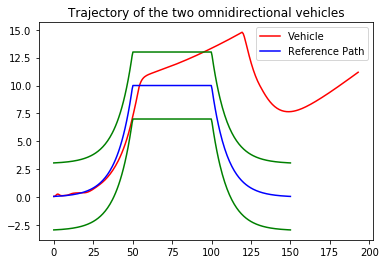

In [22]:
posx = []
posy = []
v = []
theta = []
for i in agent_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [46]:
N = len(x_path)
H = 10  # Number of time steps in trajectory.
n = 10
n_init = 0
#n_end = 250
n_end = N - H - 1
x0 = x_path[n_init]  # Initial state.
# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []
nn_traj = []
mpc_traj= []
traj = []

for i in range(n_init, n_end):
    print(">>>>>Step {} at {}".format(i, x0))
    x_path_ = x_path[i: i + H]
    x_nn = []
    for j in [x0] + x_path_[0 : n]:
        for k in j:
            x_nn.append(k)
    u = agent.run([x_nn])
    #print("NN outputs control")

    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    if i <= N - n - 1:
        n_ilqr =  n  
    else:
        n_ilqr = N - i - 1
    x_path_ilqr = x_path[i + 1: i + 1 + n_ilqr]
    us_init = np.zeros((n_ilqr - 1, dynamics.action_size))
    #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
    
    cost_ = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = [.5, .5], q2 = [1., 1.], \
                   x_path = x_path_ilqr, \
                   x_nominal = nominal)
    ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
    xs, us = ilqr_.fit(x0_, us_init, on_iteration=on_iteration)
    #print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        print("Utilize NN output {}".format(u))
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            x_path_ = x_path[i: i + n]
            cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = [.5, .5], q2 = [1., 1.], \
                   x_path = x_path_, \
                   x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, n - 1)
            us_init = np.zeros((n - 1, dynamics.action_size))
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        x0_ = dynamics.f(x0, us[0], i)
        print("Utilize MPC output {}".format(us[0]))
    x0 = x0_[0][:]

>>>>>Step 0 at [0.0, 0.06737946999085467, 10, 0.006737845034422798]
iteration 0 accepted [0.01444852] [ 5.00781803  0.10171955 10.01701823  0.01223941] [-0.00079176  0.00793762]
Utilize NN output [[0.39677832 0.07452384]]
>>>>>Step 1 at [ 0.50046013  0.07075154 10.01885945  0.04393093]
iteration 0 accepted [0.03445143] [ 5.51629732  0.10412349 10.03372302  0.01194267] [-0.00158318  0.00996498]
Utilize NN output [[0.39360696 0.01542107]]
>>>>>Step 2 at [ 1.00138741  0.09277192 10.03758273  0.0516554 ]
iteration 0 accepted [0.05662032] [6.02594409e+00 1.07808227e-01 1.00503896e+01 9.46674158e-03] [-0.00237698  0.00776321]
Utilize NN output [[ 0.39187992 -0.02253345]]
>>>>>Step 3 at [ 1.50306273  0.11870923 10.05623172  0.04034824]
iteration 0 accepted [0.08011549] [6.53685608e+00 1.13025625e-01 1.00670263e+01 6.62673761e-03] [-0.00317177  0.00363523]
Utilize NN output [[ 0.39122853 -0.03837758]]
>>>>>Step 4 at [ 2.00593023  0.13901006 10.07485266  0.02106102]
iteration 0 accepted [0.1055

Utilize NN output [[0.433387   0.00376766]]
>>>>>Step 37 at [19.15001798  0.44215393 10.72137383  0.03764214]
iteration 0 accepted [11.34158217] [24.48772339  0.70892592 10.65489573  0.05447758] [-0.03169096 -0.00396509]
Utilize NN output [[0.43559507 0.00383071]]
>>>>>Step 38 at [19.68621905  0.46234723 10.74187316  0.03969565]
iteration 0 accepted [12.2784536] [25.03247438  0.74804682 10.67292379  0.05755852] [-0.03258187 -0.00412017]
Utilize NN output [[0.43771487 0.00471358]]
>>>>>Step 39 at [20.22340388  0.48368234 10.76246059  0.04222727]
iteration 0 accepted [13.27394488] [25.57797838  0.79213824 10.69100854  0.06148774] [-0.03347664 -0.00368556]
Utilize NN output [[0.43922922 0.01035522]]
>>>>>Step 40 at [20.76156301  0.50642084 10.78311085  0.04779945]
iteration 0 accepted [14.33063975] [26.12429481  0.83965687 10.70914797  0.06577078] [-0.03437517 -0.00302606]
iteration 60 accepted [14.3147675] [26.10591129  0.9558781  10.71424962  0.16599341] [-0.03695878  0.        ]
Utiliz

Utilize NN output [[0.5012103  0.02230353]]
>>>>>Step 75 at [40.10798177  2.85713844 11.55215176  0.2694558 ]
iteration 0 accepted [106.62457406] [45.45604415  4.84835999 11.39271886  0.25441587] [-0.06870067  0.00781174]
Utilize NN output [[0.5019576 0.0208209]]
>>>>>Step 76 at [40.66530557  3.01105585 11.57533453  0.28148037]
iteration 0 accepted [112.72915705] [46.01921027  5.0057312  11.41353473  0.24212931] [-0.06978352  0.01464787]
Utilize NN output [[0.5024214  0.01952458]]
>>>>>Step 77 at [41.22185229  3.17198567 11.59853549  0.29277911]
iteration 0 accepted [120.0754354] [46.58876528  5.14531069 11.43432393  0.22272097] [-0.07087718  0.02363791]
Utilize NN output [[0.5029187  0.01986577]]
>>>>>Step 78 at [41.77765637  3.33952831 11.62175597  0.30429829]
iteration 0 accepted [129.94131044] [47.1737221   5.23644047 11.45495275  0.18891094] [-0.07198339  0.03608822]
Utilize NN output [[0.50162524 0.01535168]]
>>>>>Step 79 at [42.33260014  3.51380958 11.64492569  0.31321826]
itera

Utilize NN output [[ 0.37220734 -0.01423914]]
>>>>>Step 112 at [5.98404687e+01 1.01241117e+01 1.20158666e+01 1.62653133e-02]
iteration 0 accepted [262.88709415] [ 6.57288041e+01  9.51879396e+00  1.18070962e+01 -7.10705749e-03] [-0.090263    0.00508833]
Utilize NN output [[ 0.3711241  -0.01065657]]
>>>>>Step 113 at [6.04416262e+01 1.01338906e+01 1.20336154e+01 9.86315938e-03]
iteration 0 accepted [272.29566028] [ 6.63336959e+01  9.49902894e+00  1.18229722e+01 -8.58923776e-03] [-0.09113872  0.00410527]
Utilize NN output [[ 0.3700653  -0.00794539]]
>>>>>Step 114 at [6.10437202e+01 1.01398294e+01 1.20513178e+01 5.08267136e-03]
iteration 0 accepted [282.0255166] [ 6.69407511e+01  9.48391046e+00  1.18388131e+01 -9.63805578e-03] [-0.09201615  0.00335661]
Utilize NN output [[ 0.36902386 -0.00590498]]
>>>>>Step 115 at [6.16467198e+01 1.01428942e+01 1.20689747e+01 1.52457065e-03]
iteration 0 accepted [292.07846954] [ 6.75497164e+01  9.47238163e+00  1.18546215e+01 -1.03509082e-02] [-0.092895    0

Utilize NN output [[ 3.3838403e-01 -4.7763810e-05]]
>>>>>Step 144 at [ 7.95076984e+01  1.00085249e+01  1.25610938e+01 -9.24787868e-03]
iteration 0 accepted [744.03523238] [ 8.56632161e+01  9.42287018e+00  1.23006678e+01 -6.47548217e-03] [-0.11854257 -0.00087825]
Utilize NN output [[ 3.3726811e-01 -5.1936135e-05]]
>>>>>Step 145 at [ 8.01361325e+01  1.00027131e+01  1.25773456e+01 -9.28049742e-03]
iteration 0 accepted [765.98436495] [ 8.63003350e+01  9.42186558e+00  1.23155856e+01 -6.32858967e-03] [-0.11942597 -0.00093516]
Utilize NN output [[ 3.3614835e-01 -4.9432740e-05]]
>>>>>Step 146 at [ 8.07653777e+01  9.99687320e+00  1.25935474e+01 -9.31158405e-03]
iteration 0 accepted [788.417262] [ 8.69382446e+01  9.42086674e+00  1.23304697e+01 -6.18472765e-03] [-0.12030907 -0.00098973]
Utilize NN output [[ 3.3505026e-01 -4.1684136e-05]]
>>>>>Step 147 at [ 8.13954316e+01  9.99100623e+00  1.26096999e+01 -9.33783161e-03]
iteration 0 accepted [811.34061324] [ 8.75769595e+01  9.41997853e+00  1.234532

Utilize NN output [[ 2.9877335e-01 -4.7227368e-05]]
>>>>>Step 177 at [ 1.00659800e+02  9.77335971e+00  1.30694789e+01 -1.25579247e-02]
iteration 0 accepted [1337.35508172] [99.96101863  6.65209172 12.77797388 -2.7329638 ] [-0.13663329  0.85220807]
Utilize NN output [[ 2.9750964e-01 -4.6810135e-05]]
>>>>>Step 178 at [ 1.01313584e+02  9.76514912e+00  1.30839305e+01 -1.25885139e-02]
iteration 0 accepted [1309.52187592] [100.28630197   8.13531814  12.79219934  -3.45653485] [-0.1363865   1.06445472]
Utilize NN output [[ 2.9624423e-01 -4.6392903e-05]]
>>>>>Step 179 at [ 1.01968088e+02  9.75690944e+00  1.30983241e+01 -1.26188639e-02]
iteration 0 accepted [1380.49136492] [101.32141924   9.04935021  12.80585476  -3.97526137] [-0.13719934  1.21404396]
Utilize NN output [[ 2.9497772e-01 -4.4604763e-05]]
>>>>>Step 180 at [ 1.02623311e+02  9.74864084e+00  1.31126596e+01 -1.26480763e-02]
iteration 0 accepted [1517.59113266] [102.4172006    9.40764706  12.81930311  -4.29993814] [-0.13827429  1.307154

Utilize NN output [[0.2693889  0.31042448]]
>>>>>Step 212 at [1.21311119e+02 3.73099316e+00 1.30663790e+01 3.88374059e-02]
iteration 0 accepted [2599.85625301] [127.4630662    2.15026115  12.75958474  -0.23723176] [-0.1499193   0.10175116]
Utilize NN output [[0.2650722  0.05657862]]
>>>>>Step 213 at [1.21964269e+02 3.75637256e+00 1.30793307e+01 7.57619021e-02]
iteration 0 accepted [2609.72256984] [127.98502468   1.83825206  12.772188    -0.18851715] [-0.15043162  0.07297633]
Utilize NN output [[ 0.26147276 -0.06138539]]
>>>>>Step 214 at [1.22616678e+02 3.80589512e+00 1.30921143e+01 3.56682613e-02]
iteration 0 accepted [2587.83668738] [128.29721775   1.34497055  12.78495393  -0.16874247] [-0.15067717  0.04571169]
Utilize NN output [[ 0.25889084 -0.09831299]]
>>>>>Step 215 at [ 1.23271184e+02  3.82925010e+00  1.31047772e+01 -2.84814378e-02]
iteration 0 accepted [2548.84265364] [128.43721      0.70861519  12.79766312  -0.21305019] [-0.15074632  0.03943976]
Utilize NN output [[ 0.2566344  

Utilize NN output [[0.21898903 0.00481481]]
>>>>>Step 248 at [ 1.44893549e+02  2.68247622e-01  1.34883628e+01 -9.12997402e-02]
iteration 0 accepted [4653.34566052] [ 1.51216106e+02 -1.37376791e+00  1.31592994e+01 -6.65156831e-02] [-0.17661571 -0.0072924 ]
Utilize NN output [[0.2178916  0.00452942]]
>>>>>Step 249 at [ 1.45565425e+02  2.06734483e-01  1.34990881e+01 -8.82450350e-02]
iteration 0 accepted [4736.80404771] [ 1.51928426e+02 -1.34840157e+00  1.31694449e+01 -6.26960165e-02] [-0.17738164 -0.00759706]
Utilize NN output [[0.21678951 0.00434024]]
>>>>>Step 250 at [ 1.46238019e+02  1.47226865e-01  1.35097609e+01 -8.53155872e-02]
iteration 0 accepted [4820.7632544] [ 1.52639039e+02 -1.32255058e+00  1.31795456e+01 -5.91949826e-02] [-0.17814267 -0.00782362]
Utilize NN output [[0.21568324 0.00421102]]
>>>>>Step 251 at [ 1.46911315e+02  8.96444681e-02  1.35203809e+01 -8.24711084e-02]
iteration 0 accepted [4905.21507974] [ 1.53347993e+02 -1.29633350e+00  1.31896010e+01 -5.59884656e-02] [-0

Utilize NN output [[0.18203889 0.00107918]]
>>>>>Step 281 at [ 1.67385295e+02 -1.03691145e+00  1.38139318e+01 -3.59923921e-02]
iteration 0 accepted [7705.26653349] [ 1.74180238e+02 -7.71135644e-01  1.34689631e+01 -2.33088351e-02] [-0.19977303 -0.0041152 ]
Utilize NN output [[0.1809279  0.00101981]]
>>>>>Step 282 at [ 1.68075768e+02 -1.06177396e+00  1.38228808e+01 -3.52880099e-02]
iteration 0 accepted [7810.01914821] [ 1.74871024e+02 -7.61484199e-01  1.34775071e+01 -2.30151976e-02] [-0.20042389 -0.00398881]
Utilize NN output [[0.17981923 0.00096784]]
>>>>>Step 283 at [ 1.68766704e+02 -1.08616584e+00  1.38317761e+01 -3.46190936e-02]
iteration 0 accepted [7915.65177957] [ 1.75562003e+02 -7.52286933e-01  1.34860008e+01 -2.27378107e-02] [-0.2010725  -0.00386813]
Utilize NN output [[0.1787125  0.00091896]]
>>>>>Step 284 at [ 1.69458099e+02 -1.11011089e+00  1.38406178e+01 -3.39835488e-02]
iteration 0 accepted [8022.16463819] [ 1.76253175e+02 -7.43395687e-01  1.34944441e+01 -2.24747465e-02] [-

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

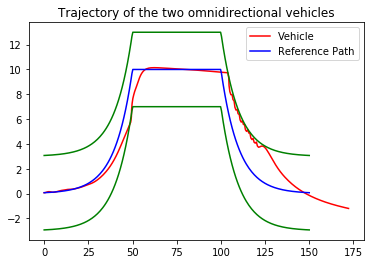

In [47]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])



The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

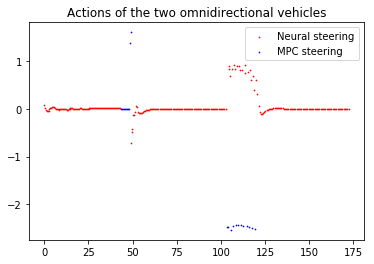

In [23]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 


As the computation of the QP problem is immensely expensive, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta g(x_k, \theta_i) \approx \delta u_k -\delta x_k^T \nabla_x g(x_k, \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= g(x_k, \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||g(x_k, \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[g(x_k, \theta_i) - u^*_k]^T \Sigma^{-1}[g(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta g(x_k, \theta_i)[g(x_k, \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a dataset $D=\{(x_k, u^*_k)\}$, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta g(x_k, \theta_i)[g(x_k, \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta g(x_k, \theta_i)[g(x_k, \theta_i) - u^*_k] [g(x_k, \theta_i) - u^*_k]^T\nabla_\theta g(x_k, \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x g(x_k, \theta_i)][g(x_k, \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x g(x_k, \theta_i)][g(x_k, \theta_i) - u^*_k] [g(x_k, \theta_i) - u^*_k]^T[\delta u_k -\delta x_k^T \nabla_x g(x_k, \theta_i)]^T\}
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $g(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$.

<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
